In [2]:
import pickle
from diffusion.sampling import *
from diffusion.likelihood import mmff_energy
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True 
import py3Dmol
from rdkit import Chem, Geometry
from ipywidgets import interact, Dropdown
import matplotlib.pyplot as plt
from rdkit.Chem import rdMolAlign
from termcolor import colored
from rdkit.Chem import rdMolTransforms
from utils.standardization import fast_rmsd


/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch_geometric/typing.py:99: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(
/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [3]:
def get_bond_lengths(mol):
    assert mol.GetNumConformers() == 1
    bond_lengths = []
    for bond in mol.GetBonds():
        bond_lengths.append(rdMolTransforms.GetBondLength(mol.GetConformer(),bond.GetBeginAtom().GetIdx(), bond.GetEndAtom().GetIdx() ) )
    return torch.Tensor(bond_lengths)

def get_bond_angles(mol):
    assert mol.GetNumConformers() == 1
    bond_angles = []
    for bond in mol.GetBonds():
        atom1 = bond.GetBeginAtom()
        atom2 = bond.GetEndAtom()
        for neighbor in atom2.GetNeighbors():
            if neighbor.GetIdx() != atom1.GetIdx():
                angle = rdMolTransforms.GetAngleRad(mol.GetConformer(),   
                                                    atom1.GetIdx(), 
                                                    atom2.GetIdx(), 
                                                    neighbor.GetIdx())
                bond_angles.append(angle)
    return torch.Tensor(bond_angles)

def get_torsion_angles(mol):
    assert mol.GetNumConformers() == 1
    torsion_angles = []
    for bond in mol.GetBonds():
        atom1 = bond.GetBeginAtom()
        atom2 = bond.GetEndAtom()
        
        # Get neighboring atoms
        for neighbor1 in atom2.GetNeighbors():
            if neighbor1.GetIdx() != atom1.GetIdx():
                # Calculate the angle
                for neighbor2 in neighbor1.GetNeighbors():
                    if neighbor2.GetIdx() != atom2.GetIdx() and neighbor2.GetIdx() != atom1.GetIdx():
                        torsion = rdMolTransforms.GetDihedralRad(mol.GetConformer(), 
                                                                 atom1.GetIdx(), 
                                                                 atom2.GetIdx(), 
                                                                 neighbor1.GetIdx(), 
                                                                 neighbor2.GetIdx())
                        torsion_angles.append(torsion)
    return torch.Tensor(torsion_angles)

def get_stds_internal_coords(mols):
    
    all_bond_lengths = [get_bond_lengths(mol) for mol in mols]
    all_bond_angles = [get_bond_angles(mol) for mol in mols]
    all_torsion_angles = [get_torsion_angles(mol) for mol in mols]
    bond_lengths_std = torch.stack(all_bond_lengths).std(dim=0).mean()
    bond_angles_std = torch.stack(all_bond_angles).std(dim=0).mean()
    torsion_angles_std = torch.stack(all_torsion_angles).std(dim=0).mean()
    return bond_lengths_std, bond_angles_std, torsion_angles_std

def get_rmsds(mols, mols_optimized):
    '''
    This function compares a set of molecules with their optimized versions and returns the RMSDs between each pair (non-optimized, optimized).
    '''
    rmsds = []
    for conf_idx in range(len(mols)):
        mol0, mol1 = mols[conf_idx], mols_optimized[conf_idx]
        rdMolAlign.AlignMol(mol0, mol1)
        rmsds.append(fast_rmsd(mol0, mol1 , conf1=0, conf2=0) )
    return rmsds

## Understanding relaxation

In [5]:
# load conformers_20steps.pkl
#conformers_train = pickle.load(open('true_conformers_train_1smiles.pkl', 'rb'))
conformers_train = None
conformers_gen = pickle.load(open('conformers_20steps_train_1smiles.pkl', 'rb'))
conformers_optimized = pickle.load(open('conformers_20steps_train_1smiles_optimized.pkl', 'rb'))
smis = list(conformers_gen.keys())

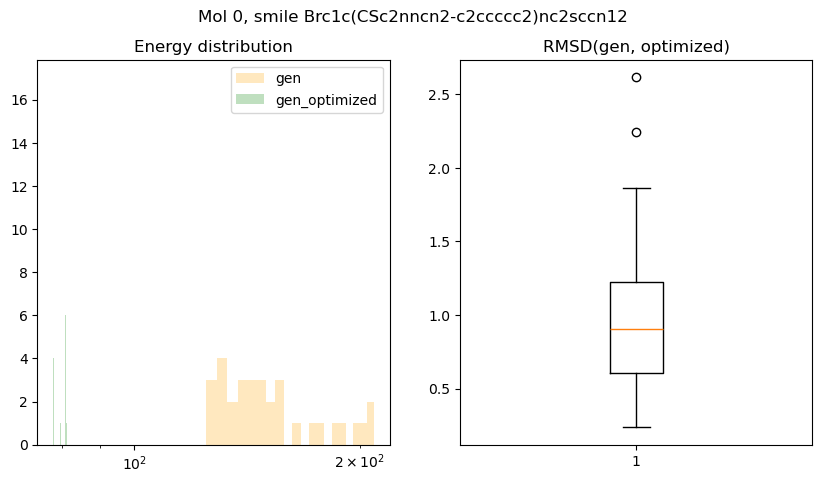

In [6]:
for i, smile in enumerate(smis): 
    #Plt figure with 2 subfigures
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    #mols_train, mols_gen, mols_optimized = conformers_train[smile], conformers_gen[smile], conformers_optimized[smile]
    mols_train, mols_gen, mols_optimized = conformers_train, conformers_gen[smile], conformers_optimized[smile]
    #Plot the hists in the first subfigure
    #ax[0].hist([mmff_energy(mol) for mol in mols_train], bins=20, color = 'blue', label='train', alpha=0.25  )
    ax[0].hist([mmff_energy(mol) for mol in mols_gen], bins=20, color = 'orange',label='gen', alpha=0.25)
    ax[0].hist([mmff_energy(mol) for mol in mols_optimized], bins=20, color = 'green',label='gen_optimized', alpha=0.25)
    ax[0].legend()
    ax[0].set_xscale('log')
    ax[0].set_title(f'Energy distribution')
    # Plot the RMSD in the second subfigure
    rmsds = get_rmsds(mols_gen, mols_optimized)
    ax[1].boxplot(rmsds)
    ax[1].set_title(f'RMSD(gen, optimized)')
    # add title to the whole figure
    fig.suptitle(f'Mol {i}, smile {smile}')
    #Add title for the whole figure
    i+=1
    #if i ==1:
        #break


Text(0.5, 1.0, 'RMSD')

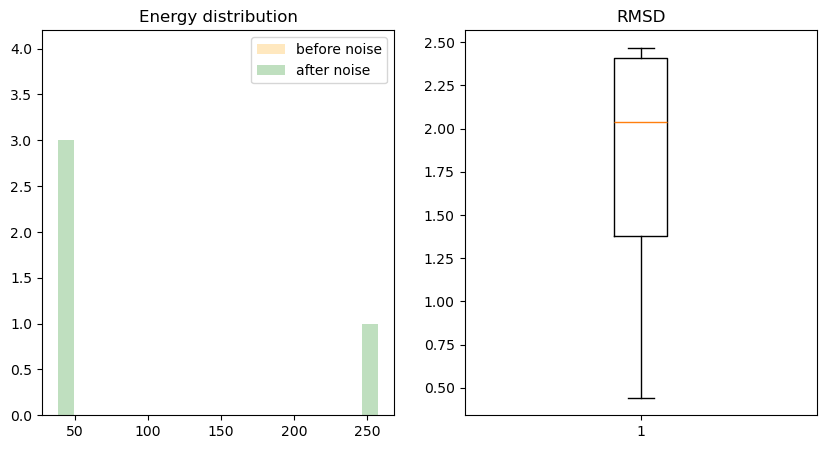

In [12]:
samples_before_perturb = pickle.load(open('samples_before_perturb.pkl', 'rb'))
samples_after_perturb = pickle.load(open('samples_after_perturb.pkl', 'rb'))
#Plt figure with 2 subfigures
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#Plot the hists in the first subfigure
ax[0].hist([mmff_energy(x.mol) for x in samples_before_perturb], bins=20, color = 'orange',label='before noise', alpha=0.25)
ax[0].hist([mmff_energy(x.mol) for x in samples_after_perturb], bins=20, color = 'green',label='after noise', alpha=0.25)
ax[0].legend()
ax[0].set_title(f'Energy distribution')
# Plot the RMSD in the second subfigure
rmsds = get_rmsds([x.mol for x in samples_before_perturb], [x.mol for x in samples_after_perturb])
ax[1].boxplot(rmsds)
ax[1].set_title(f'RMSD')


In [6]:
ix = 0
mol0 = conformers_gen[smis[0]][ix]
mol1 = samples_before_perturb[ix].mol
mol2 = samples_after_perturb[ix].mol
rdMolAlign.AlignMol(mol0, mol1)
rdMolAlign.AlignMol(mol2, mol1)
# Convert to mol blocks
mol0_block = Chem.MolToMolBlock(mol0)
mol1_block = Chem.MolToMolBlock(mol1)
mol2_block = Chem.MolToMolBlock(mol2)

view = py3Dmol.view(width=400, height=400)
view.addModel(mol0_block, "mol")
view.addModel(mol1_block, "mol")
view.addModel(mol2_block, "mol")
view.setStyle({'model': 0}, {'stick': {'color': 'green'}})
view.setStyle({'model': 1}, {'stick': {'color': 'red'}})
view.setStyle({'model': 2}, {'stick': {'color': 'blue'}})
view.addLabel('Gen (green) || Before (red) after (blue) noising}',{'position': {'x': 0, 'y': 8, 'z': 0}, 
               'backgroundColor': 'white', 
               'fontColor': 'black', 
               'fontSize': 16, 
               'alignment': 'topCenter'})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Let's look at the internal coordinate differences before vs after relaxation, for bond lengths, bond angles and torsion angles:

In [7]:
for smile in smis:
    print(f'MOL={smile}')
    bond_lengths_diffs = 0
    bond_angles_diffs = 0
    torsion_angles_diffs = 0
    mols_train, mols_gen, mols_optimized = conformers_train[smile], conformers_gen[smile], conformers_optimized[smile]
    for conf_idx in range(len(mols_train)):
        mol1, mol2 =mols_gen[conf_idx], mols_optimized[conf_idx]
        bond_lengths_diff, bond_angles_diff, torsion_angles_diff = get_stds_internal_coords([mol1, mol2])
        bond_lengths_diffs +=bond_lengths_diff
        bond_angles_diffs +=bond_angles_diff
        torsion_angles_diffs += torsion_angles_diff
    print(f'Mean Bond length std: {bond_lengths_diffs/len(mols_train):.2f} Å, Mean Bond angles std: {bond_angles_diffs/len(mols_train):.2f} rad, Mean Torsion angles std: {torsion_angles_diffs/len(mols_train):.2f} rad' )


MOL=COc1cccc(C(C[N+](=O)[O-])c2c(C)[nH]n(-c3ccccc3)c2=O)c1
Mean Bond length diff: 0.03 Å, Mean Bond angles diff: 0.08 rad, Mean Torsion angles diff: 1.32 rad
MOL=S=C(NCc1ccc2c(c1)OCO2)NC1CC1
Mean Bond length diff: 0.02 Å, Mean Bond angles diff: 0.07 rad, Mean Torsion angles diff: 1.04 rad
MOL=CCN(CC)C(C(=O)NC1CCCCC1)c1ccc(C)cc1
Mean Bond length diff: 0.02 Å, Mean Bond angles diff: 0.06 rad, Mean Torsion angles diff: 1.06 rad
MOL=Cc1nc(-c2nc(-c3c(C(=O)NNC(=O)Nc4ccccc4)noc3C)cs2)cs1
Mean Bond length diff: 0.04 Å, Mean Bond angles diff: 0.09 rad, Mean Torsion angles diff: 1.40 rad
MOL=CCC1(C)Cc2c(C#N)c(N)n(N)c(=S)c2CO1
Mean Bond length diff: 0.03 Å, Mean Bond angles diff: 0.08 rad, Mean Torsion angles diff: 1.27 rad
MOL=CC(C(=O)Nc1ccccc1F)N1CC[NH+](C)CC1
Mean Bond length diff: 0.03 Å, Mean Bond angles diff: 0.07 rad, Mean Torsion angles diff: 1.11 rad
MOL=[NH3+]CCCP(=O)(O)CCc1ccccc1
Mean Bond length diff: 0.02 Å, Mean Bond angles diff: 0.05 rad, Mean Torsion angles diff: 1.19 rad
MOL=Cc1c

Hmmmm, interesting, the torsion angles change a lot with relaxation. But why does relaxation need to go so far in terms of RMSD? Why doesn't it go to the closest 'ground-truth' conformer?

Well, if we look at the eval metrics for this set of molecules: 

 - threshold 0.75:

- Recall Coverage: Mean = 61.66, Median = 82.02

- Recall AMR: Mean = 0.6300, Median = 0.5793

- Precision Coverage: Mean = 35.80, Median = 42.31

- Precision AMR: Mean = 0.9013, Median = 0.7905

The precision AMR is around 0.9, i.e. it is the same order of magnitude of relaxtion. So the results with relaxation are not that surprising

**Training conformers after conformer matching have low energy!** Ca laisse penser que c'est le modele qui est pas assez bon

        - Plot : bond lengths and angles distribution of training conformers after confs matching. Ot has very low variance, so it makes sense to fix bond lengths/angles, and it's the diff model that is pretty bad
       
        - How does this energy compare to the energy of conformers **before confs matching?** -> voir si ça vaut vraiment le coup de fixer les bond lengths/angles ou pas

## Dataset Exploration

In [5]:
from utils.dataset import *
from utils.featurization import dihedral_pattern, featurize_mol, qm9_types, drugs_types

data_dir='/home/mila/l/lena-nehale.ezzine/scratch/torsional-diffusion/DRUGS/drugs/'
split_path='/home/mila/l/lena-nehale.ezzine/scratch/torsional-diffusion/DRUGS/split_boltz_10k.npy'
mode = 'train'
dataset='drugs'
transform=None
num_workers = 32
limit_molecules = 0
types = drugs_types
cache = '/home/mila/l/lena-nehale.ezzine/scratch/torsional-diffusion/cache/test_run'
pickle_dir = '/home/mila/l/lena-nehale.ezzine/scratch/torsional-diffusion/DRUGS/standardized_pickles'
boltzmann_resampler = None

dataset = ConformerDataset(data_dir, split_path, mode, dataset,
                                   types, transform,
                                   num_workers,
                                   limit_molecules,
                                   cache,
                                   pickle_dir,
                                   boltzmann_resampler)
print(f'Number of datapoints {len(dataset.datapoints)}')

loader = DataLoader(dataset=dataset,
                            batch_size=1,
                            shuffle=False )

Reusing preprocessing from cache /home/mila/l/lena-nehale.ezzine/scratch/torsional-diffusion/cache/test_run.train
Number of datapoints 9295


/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [7]:
from diffusion.score_model import TensorProductScoreModel
model = TensorProductScoreModel(in_node_features=74, in_edge_features=4,
                                   sigma_embed_dim=32,
                                   num_conv_layers=4,
                                   max_radius=5.0, radius_embed_dim=50,
                                   scale_by_sigma=True,
                                   use_second_order_repr=False,
                                   residual=True, batch_norm=True)
restart_dir = '/home/mila/l/lena-nehale.ezzine/scratch/torsional-diffusion/workdir/boltz_T300'
state_dict = torch.load(f'{restart_dir}/best_model.pt', map_location=torch.device('cpu'))
model.load_state_dict(state_dict, strict=True)
simga_max, sigma_min, steps = 0.01*3.14, 3.14, 20

/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type anno

In [11]:

def get_2dheatmap_array(data,ix0, ix1):
    '''
    Get 2Denergy heatmap. This is obtained by computing the energy for different value (linspace) of the 2 torsion angles ix0 and ix1. 
    '''
    torsion_angles_linspace = torch.linspace(0, 2*np.pi, 100)
    mols_energy_landscape = []
    for theta0 in torsion_angles_linspace:
        mols_energy_landscape.append([])
        for theta1 in torsion_angles_linspace:
            data0 = copy.deepcopy(data)
            torsion_update = np.zeros(len(data0.mask_rotate))
            torsion_update[ix0], torsion_update[ix1] = theta0, theta1
            new_pos = modify_conformer(data0.pos, data0.edge_index.T[data0.edge_mask], data0.mask_rotate, torsion_update, as_numpy=False) #change the value of the 1st torsion angle
            data0.pos = new_pos
            mol = pyg_to_mol(data0.mol, data0, mmff=False, rmsd=True, copy=True)
            mols_energy_landscape[-1].append(mol)
    energy_landscape = [[mmff_energy(mol) for mol in mols] for mols in mols_energy_landscape]
    print('energies (1st row)', energy_landscape[0])
    return energy_landscape
    

energies (1st row) [141.98474975172755, 230.16713463936654, 577.2612524007418, 2628.1728836912025, 12502.348755808334, 43561.91192304044, 117230.34399751901, 262852.3436664178, 517108.87768351624, 923173.6421266026, 1529679.4358735012, 2389540.81850222, 3558675.7920875875, 5094652.384267197, 7055285.788562259, 9497225.802978136, 12474532.138210597, 16037289.76634386, 20230285.583863616, 25091748.51499708, 30652235.79060321, 36933569.05378375, 43947963.058798306, 51697355.55405703, 60172781.102320224, 69354049.15628083, 79209547.1702199, 89696259.57842204, 100760026.59862356, 112335857.66164768, 124348584.58630256, 136713665.9281296, 149338027.78709373, 162121245.9022898, 174956776.34306604, 187733206.48655188, 200335834.5397303, 212648078.81849277, 224553205.01088277, 235935698.6107049, 246683030.94640142, 256687159.3412523, 265846102.54085487, 274065244.2741198, 281258861.42519784, 287351329.3923306, 292278024.3907528, 295986427.694526, 298436859.58894324, 299602963.0277484, 299472237

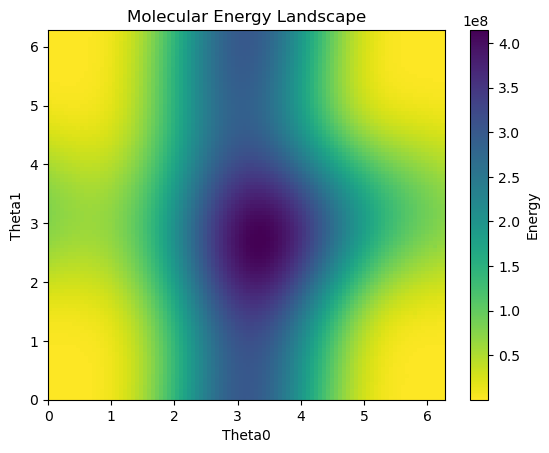

energies (1st row) [155.61340853648827, 391.3183415306686, 1329.7101930867657, 3732.944189724976, 10478.056285032122, 27366.520894022968, 62119.93628906751, 125414.31913348575, 233545.2935277865, 394667.81627224595, 613901.4352090673, 917225.9836202816, 1330722.5499490253, 1870631.3131651345, 2553654.3252679803, 3398325.160150696, 4422687.503299486, 5642021.1832917705, 7070881.2093382515, 8722065.139141966, 10604388.933879836, 12723753.47354893, 15083750.690503208, 17684036.616684493, 20520298.01902603, 23584489.03656551, 26864760.520213164, 30345439.710342765, 34007151.80475777, 37826953.81116467, 41778576.36040407, 45832714.46325189, 49957360.32770784, 54118191.974662535, 58279028.55039549, 62402302.72225251, 66449546.279187836, 70381922.76010811, 74160815.22432359, 77748314.90416351, 81107739.28551236, 84204241.73161794, 87005246.80633605, 89480943.79535952, 91604727.45174076, 93353601.22498883, 94708492.32622287, 95654502.82713382, 96181234.17628342, 96282820.9862063, 95958100.1313

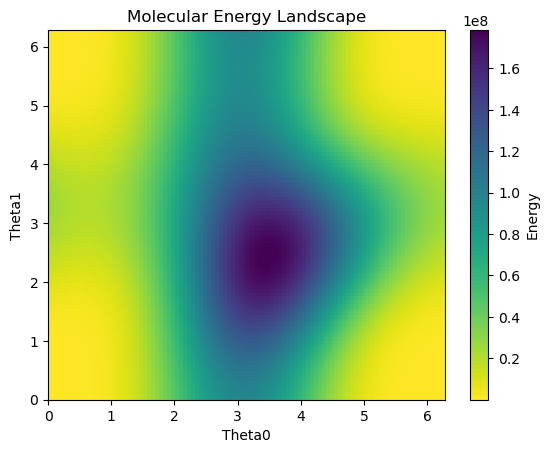

energies (1st row) [140.11410097180382, 202.7022938961677, 404.43664483562367, 950.9898814552723, 2799.5661924185165, 8116.698789965391, 20456.204478004624, 44775.9064550978, 87401.15973728866, 155936.79486691268, 259117.51483601928, 406608.27194560785, 608768.9800327205, 876397.2686862746, 1220456.7111959357, 1651800.6293410703, 2180909.655209686, 2817693.6855168473, 3571451.1024858104, 4450472.393928733, 5459247.270794948, 6601823.398273639, 7882485.3308364125, 9292774.590129191, 10840018.886866389, 12522854.909110297, 14333463.323937448, 16263147.8699878, 18301524.01003752, 20436228.368342746, 22652954.70939382, 24935594.764802236, 27266393.704420406, 29626178.91044625, 31994594.488902945, 34350380.466264084, 36671634.23892379, 38936130.2642684, 41121637.7260711, 43206206.87165846, 45168500.26640447, 46988098.301371954, 48645787.31375545, 50123850.419063255, 51406322.8313123, 52479244.25024345, 53330818.80062485, 53951648.78307459, 54334835.9697647, 54476094.43532506, 54373824.47506

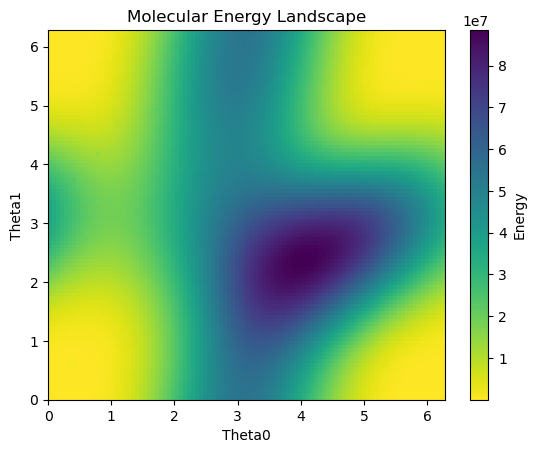

energies (1st row) [148.3220290535956, 237.5966341319564, 505.51995060030345, 1609.0501953943321, 6687.473912750808, 24086.957742288603, 68801.89954716178, 162691.1076945621, 334172.57060595194, 617587.1213665059, 1052480.0343738887, 1683098.7802222907, 2558475.3280786467, 3725723.9090200644, 5220168.594328686, 7101127.024758311, 9421097.185100885, 12221431.727793584, 15541118.998807631, 19414915.783179156, 23871701.961017925, 28933265.236906137, 34613495.968602836, 40917771.49333704, 47842345.453311265, 55374036.53669762, 63489980.96691636, 72157567.07581723, 81334616.91588484, 90969564.70699196, 101001959.51910363, 111363090.45255697, 121976652.59355588, 132759696.32486163, 143623605.41951454, 154475213.2548498, 165218028.8208782, 175753427.93926406, 185982178.01329148, 195805510.7614817, 205126720.14080608, 213852371.0444278, 221893679.30174974, 229167756.8768032, 235598774.34408662, 241119134.30051312, 245670282.6546128, 249203642.65675426, 251681358.5748236, 253076784.9377261, 253

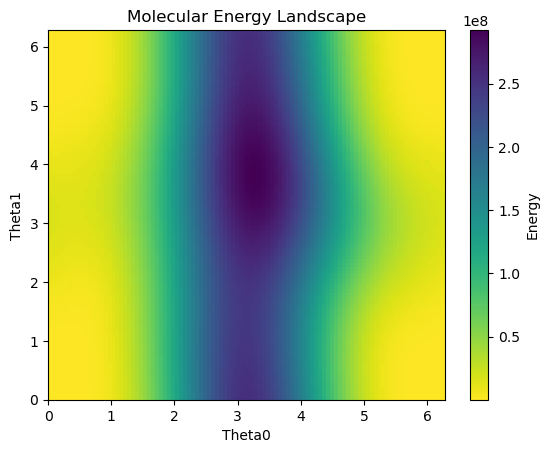

energies (1st row) [142.15537668861487, 216.48445906114387, 427.6342998640257, 978.6560814079589, 3282.776185606032, 11858.433227218025, 35525.33138780976, 87723.04390330143, 186349.9260688344, 353415.6258329806, 614603.8608510849, 999197.4298608031, 1544673.04923146, 2367825.9757869486, 3663910.456952963, 4453066.7294523865, 5869165.944440051, 7651785.796940051, 9780593.920139987, 12274089.4775782, 15152521.521046465, 18433653.258948375, 22118157.968007885, 26217228.47447535, 30733486.56500369, 35657116.56115977, 40973152.01844339, 46660681.788061805, 52692494.706712835, 59035067.92431313, 65648881.16526129, 72488799.18637127, 79504513.21239688, 86641156.3114541, 93840001.0961996, 101039132.5225744, 108174309.16258906, 115179762.43218613, 121989179.24903512, 128536505.06353426, 134756901.63862628, 140587685.10749397, 145969163.8050772, 150845537.00181323, 155165649.59167683, 158883777.57606095, 161960240.63729042, 164362020.951817, 166063197.42468646, 167045379.58971694, 167297900.886

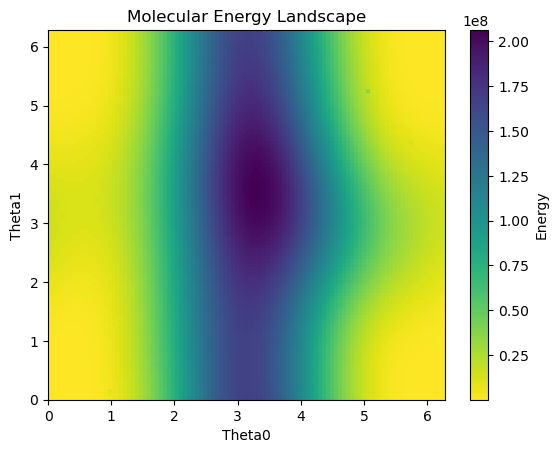

energies (1st row) [139.96358635803094, 502.32555215677786, 1628.05975898894, 3935.0284036958587, 11511.358485766117, 33996.2714905597, 88591.75896715545, 189863.5326677982, 367504.0699404933, 655331.9876917246, 1099409.2240454373, 1742213.5716312614, 2632220.099822138, 3825168.9402666725, 5355786.389687588, 7282330.546407366, 9662707.517426707, 12539684.939068694, 15955294.41471026, 19947026.374772634, 24546203.02214682, 29776877.93649405, 35654985.10642595, 42187638.725604355, 49372474.60059984, 57197282.78376521, 65639720.671131246, 74667224.8124203, 84237146.75370377, 94296952.11499035, 104784669.5433081, 115629552.23786707, 126752749.27744944, 138068257.14701232, 149483938.9288291, 160902708.60054094, 172223730.37804213, 183343699.42519906, 194158473.7611062, 204564155.2407384, 214458688.97166425, 223743319.24850613, 232323855.41299576, 240112170.0067848, 247027241.0552345, 252996538.0791615, 257956883.25594297, 261855444.38565016, 264650454.23550853, 266311893.03739327, 266821856

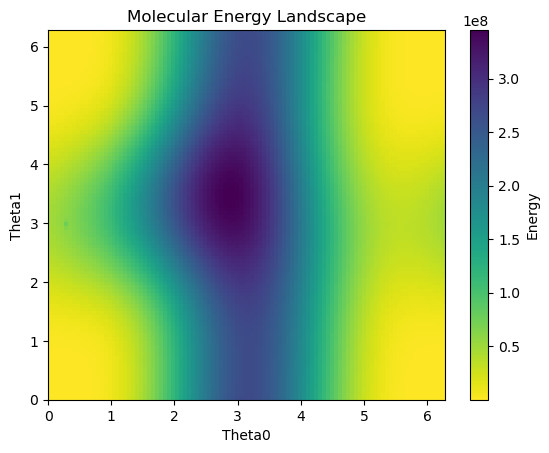

energies (1st row) [130.05870597611386, 270.3378772833754, 691.6109178430833, 2652.0553162631354, 12122.082883746174, 44880.82722956567, 129981.34325615698, 308948.29039283324, 634846.0206257502, 1171303.7705267873, 1990929.8557502371, 3173540.0124616604, 4804232.568100281, 6971338.807319799, 9764295.426262999, 13271478.272363875, 17578027.046085384, 22763687.40030269, 28900758.294907995, 36052108.20986195, 44269417.00885802, 53591461.14024015, 64042707.14310457, 75632171.31857531, 88352406.06972635, 102178823.62417774, 117069363.42973597, 132964355.39303899, 149786830.68877575, 167442870.0136155, 185822499.4802149, 204800804.49114674, 224239172.21556666, 243986979.87138548, 263883329.6788552, 283759079.0555061, 303439100.3984355, 322744286.1029542, 341494423.91900545, 359510149.6973303, 376615567.96802616, 392640847.8217575, 407424360.8193674, 420815087.5199434, 432674671.57542586, 442879562.9182835, 451322431.5664663, 457914107.13180363, 462584555.7585819, 465284050.3441048, 46598375

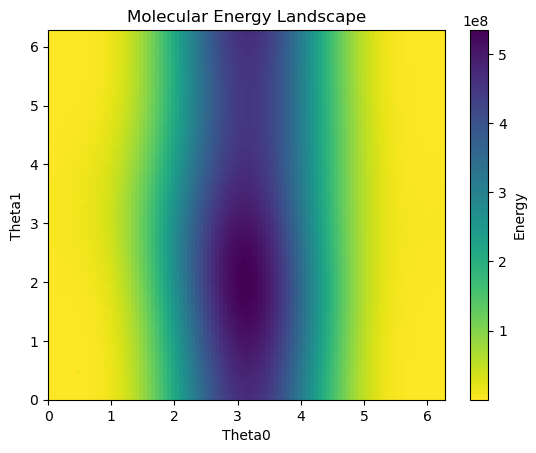

energies (1st row) [130.52407748835992, 248.0198499095276, 720.0506265050417, 3499.294918116942, 15837.924081203984, 52995.97343150031, 139251.37852858487, 308713.9297085879, 604364.9343691051, 1076568.5063419954, 1782173.6008394258, 2783179.81508406, 4145216.0497033875, 5935942.867042703, 8223409.119303313, 11074384.844244407, 14552701.221823748, 18717601.59349445, 23622198.98752229, 29311986.31303312, 35823516.043579705, 43183135.48766675, 51405978.14954623, 60495120.64283237, 70440869.87850744, 81220348.52795501, 92797276.30738275, 105121920.50831746, 118131445.36938542, 131750239.866039, 145890625.6374733, 160453879.85040978, 175331133.79597113, 190404750.7550964, 205549767.52893606, 220635451.51648122, 235526983.11466482, 250087185.04267782, 264178593.2251178, 277665012.87789726, 290413598.4325701, 302296600.57409406, 313193244.7656405, 322991430.08638483, 331589213.59440935, 338896416.2965813, 344835785.2586737, 349344191.95032096, 352373487.26114744, 353891193.65775305, 35388103

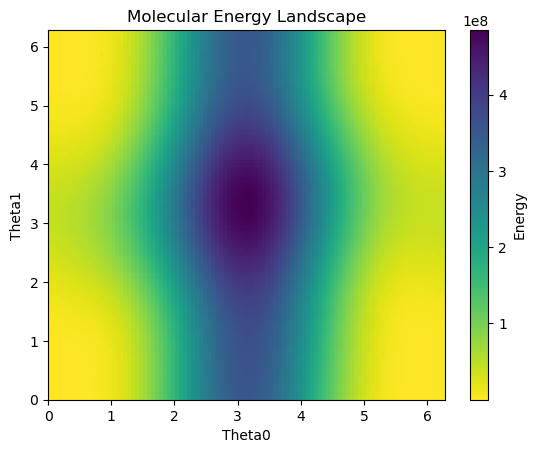

energies (1st row) [198.90990830505825, 446.99126581502753, 1220.550975030206, 3050.4199667146413, 9040.362648737455, 24862.037283667232, 59412.30598707882, 125167.48470871722, 238299.3422542872, 418562.5154077165, 688668.6351609977, 1073808.951507287, 1601073.551042579, 2298776.3817282924, 3195751.440026399, 4320630.149504931, 5701112.793954923, 7363241.711544081, 9330714.248282352, 11624212.655413244, 14260812.951027622, 17253404.019059114, 20610217.322584298, 24334435.004413456, 28423846.66581186, 32870628.417053707, 37661219.279067375, 42776264.00033468, 48190732.932255864, 53874020.356886104, 59790240.276177675, 65898612.539356835, 72153852.76953664, 78506750.5066736, 84904712.78876504, 91292526.77303936, 97612946.85205531, 103807558.90383124, 109817598.40386848, 115584627.520921, 121051418.21880522, 126162805.21229349, 130866373.74068978, 135113294.8091448, 138858940.08151567, 142063654.7176767, 144693156.2948073, 146719189.95386147, 148119799.84738353, 148879820.15692592, 148990

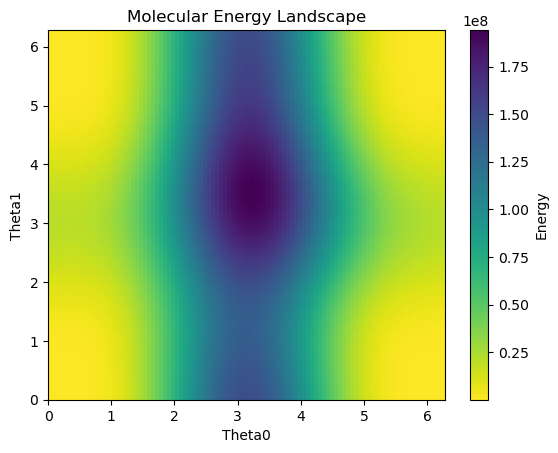

energies (1st row) [165.62927290571122, 252.73532052257156, 530.0182932238748, 1097.6188688637264, 3108.015943707425, 10571.78187345567, 31124.143346505538, 76257.75724322592, 161319.84155438776, 305232.2437638855, 530036.3452192239, 860376.2379303171, 1322941.2202565416, 1945783.0146174883, 2757558.8528540228, 3786800.510029035, 5061236.385198063, 6607118.123317816, 8448501.784377592, 10606551.63231129, 13098947.300786214, 15939320.551409151, 19136779.76438389, 22695515.312849678, 26614434.664262548, 30886946.753322665, 35500809.79677234, 40438068.49978516, 45675151.344407335, 51182958.05546846, 56927127.34909579, 62868420.135266796, 68963073.11451606, 75163355.54451178, 81418132.57274476, 87673530.11803284, 93873621.33028944, 99961130.15325134, 105878360.6636168, 111567777.99141102, 116972924.03003749, 122039227.84044522, 126714753.72634439, 130950900.85034432, 134703144.80798098, 137931743.57118413, 140602141.33994782, 142685638.61308175, 144159742.39834002, 145008472.88571236, 1452

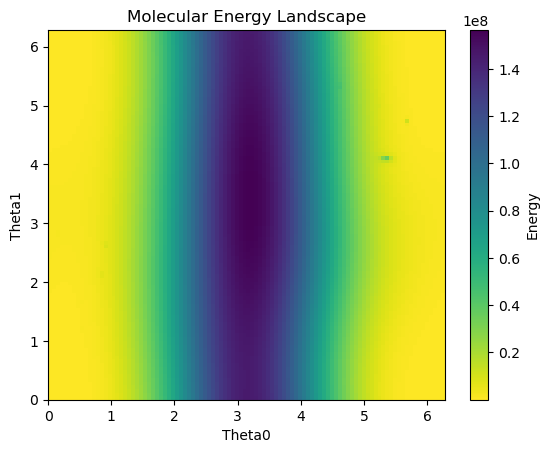

energies (1st row) [137.42545105147798, 229.45805487591073, 519.7629791789063, 1717.3550373254288, 6609.554511941156, 20893.340737721534, 53548.14819720368, 116953.82687075312, 226780.07325859152, 401698.7955639686, 662978.7814514922, 1034006.0016954464, 1539692.4739324725, 2205564.0278845048, 3056693.660591622, 4118060.201436117, 5415055.432878706, 6971197.751951019, 8805228.899576051, 10933519.82913064, 13372115.617122103, 16131395.527271405, 19216754.34238375, 22629163.61367547, 26364823.71738784, 30414903.0343151, 34765418.32010002, 39397246.74096911, 44286224.51610272, 49403287.467485696, 54714777.07732848, 60182790.239342414, 65765590.820784174, 71418117.44629319, 77092551.0483598, 82738909.33912224, 88305726.62669224, 93740717.24888691, 98991585.31518042, 104006597.82139128, 108735405.91970007, 113129773.24175373, 117144180.5369502, 120736576.58298232, 123868886.42971852, 126507697.57448864, 128624563.81263958, 130196568.40971269, 131206619.2665376, 131643686.65370286, 131502968

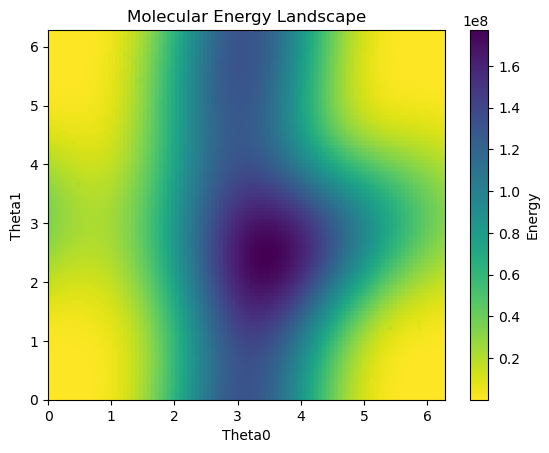

energies (1st row) [205.3712134016388, 554.3321869168703, 1690.7116118397496, 5393.300516539221, 18364.737052243872, 52215.45461803259, 124378.50607301794, 258956.48255529016, 486674.1053120193, 844204.5000627578, 1373256.8866781273, 2119500.281521143, 3132395.8961888948, 4468525.219180963, 6210678.545168184, 8398144.54220539, 10881502.69168172, 13906669.54331828, 17517003.792383697, 21715303.697870117, 26522690.88063466, 31957962.21305187, 38032662.1865952, 44749584.76627515, 52101946.030949615, 60073178.349650994, 68636934.22123596, 77756896.64279391, 87386893.92816593, 97471164.00823517, 107944968.1755924, 118735302.62029746, 129761576.86928138, 140936642.65239176, 152167856.1016812, 163358210.67500263, 174407653.53687793, 185214270.06587803, 195675919.93514088, 205691319.38114586, 215161672.69334343, 223991907.82275027, 232092113.74313125, 239378775.49187732, 245775933.12420642, 251216342.31778747, 255642388.4041099, 259006871.87155432, 261273801.4493029, 262418834.5889552, 2624296

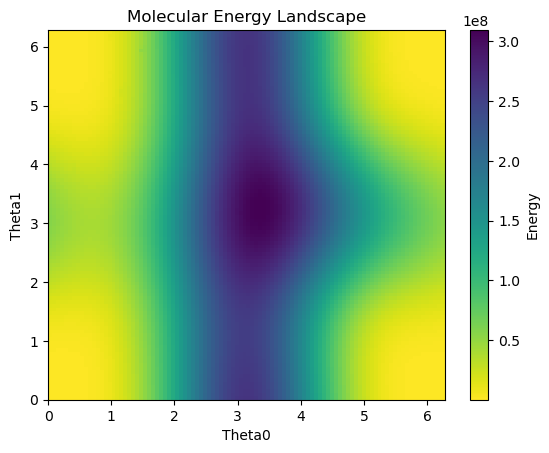

energies (1st row) [188.4867639863875, 562.4663917035891, 1798.8630750244893, 5022.413464001655, 17022.14595471907, 49242.617016846074, 124020.56857661647, 248540.76653225214, 450615.8256465258, 786243.4692787977, 1292191.0588082885, 2013743.8658416108, 3000923.9764702558, 4306088.975319783, 5982448.895805859, 8082726.873996814, 10657836.66982245, 13755572.99591929, 17419356.41247393, 21687025.78350484, 26589770.881042622, 32151079.84745871, 38385878.95117244, 45299845.80766531, 52888763.85035895, 61138129.05272763, 70022931.40442325, 79507567.74767476, 89546021.24072596, 100082041.4623074, 111049751.8236021, 122374270.63638641, 133972437.40626748, 145753891.60724777, 157622034.60525042, 169475394.17524013, 181208809.89851242, 192714848.58418128, 203885352.82283282, 214612692.66350913, 224791446.66334116, 234319811.45111996, 243100992.63913906, 251044602.69127932, 258067946.5062307, 264097288.10256505, 269068711.09996057, 272929232.83341455, 275637468.7953067, 277164270.5510346, 277493

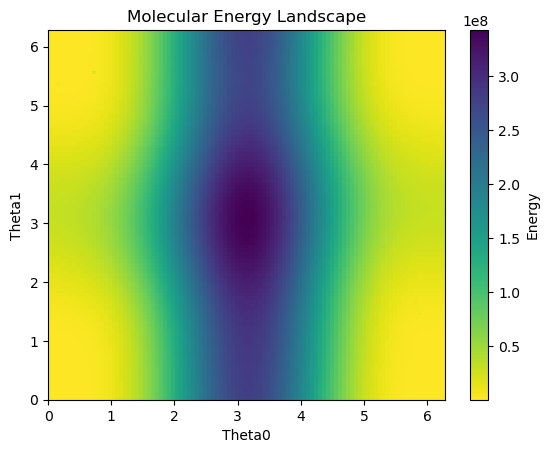

energies (1st row) [200.9806146029529, 314.2575247453792, 600.9306103487187, 1116.007918520173, 2514.9865887001874, 6034.505223388608, 13568.090919201228, 27995.64657474849, 53351.808128742065, 94827.33634433628, 158670.16233746128, 252018.73285599492, 382719.4535079057, 559196.4617039198, 790359.5131216447, 1085493.6827339998, 1454110.0743200197, 1907330.7325016102, 2465848.2874868293, 3097744.640417115, 3797088.5581754036, 4622868.757956335, 5563923.37340088, 6615836.833592963, 7776330.143315272, 9044322.25245986, 10417413.906737147, 11890323.172085077, 13455867.21426782, 15105228.911041446, 16827986.673096105, 18612199.83160286, 20444513.410046354, 22310314.68782509, 24193916.831522364, 26078763.037405517, 27947639.40568289, 29782905.214524437, 31566767.5629144, 33281493.99656241, 34909682.46677936, 36434513.01179698, 37839992.659558155, 39111179.61467203, 40234423.25141545, 41197538.746151924, 41990007.74897754, 42603127.94525056, 43030143.53181187, 43266343.19773034, 43309124.5347

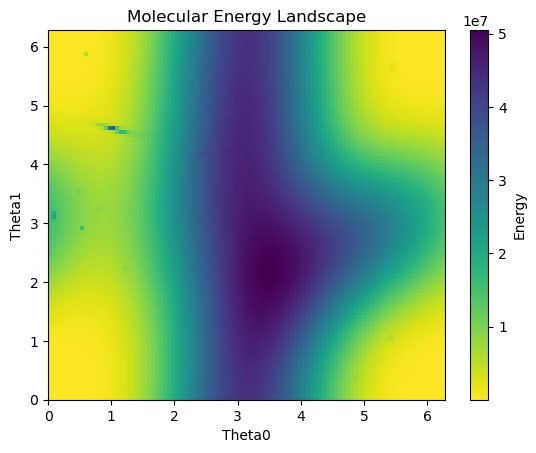

energies (1st row) [125.54364107623913, 277.1621693632848, 828.4936314598041, 2582.3760094379963, 8333.950843733453, 23279.870133577828, 55168.00134237238, 114438.83161859868, 214098.9572025383, 369360.1330126923, 598024.6900979012, 919718.7835440045, 1354959.300990642, 1924919.138717674, 2650954.6049854527, 3554036.171350064, 4654197.223411708, 5969994.618994071, 7517998.205325592, 9312310.888586394, 11364141.030609487, 13681397.635646643, 16268359.946882224, 19125421.007009994, 22248863.473307576, 25630736.328864694, 29258797.60992489, 33116504.19402842, 37183153.99277144, 41433998.47269934, 45840494.77790513, 50370637.0337564, 54989283.48910586, 59658609.26343139, 64338569.68575967, 68987432.35974026, 73562323.15800864, 78019803.35660894, 82316537.12365882, 86409775.29748145, 90258043.65399386, 93821724.66373324, 97063600.21027459, 99949414.86320534, 102448361.23621318, 104533569.83824822, 106182394.2064291, 107376876.71460094, 108103917.18358025, 108355535.58498554, 108128913.81645

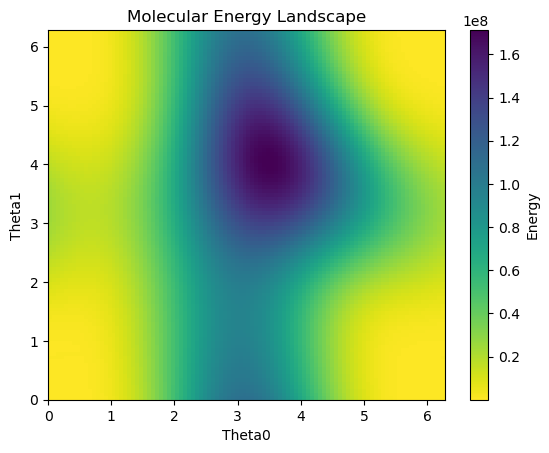

energies (1st row) [153.85624039908464, 359.906601302565, 897.28376669592, 3069.228820702185, 11536.516216153439, 35830.38895690318, 91805.61467053366, 202171.32805350985, 396243.3725448096, 709304.3862733218, 1181763.8398053013, 1858175.3162057307, 2786129.748366386, 4015070.3490156825, 5595067.114769066, 7575627.371888131, 10004515.49589519, 12926476.033238983, 16382011.508786883, 20406272.86955494, 25028084.213324063, 30268970.050235737, 36142357.163486846, 42652946.11081534, 49796105.21153195, 57557544.66478692, 65913095.34672448, 74828648.57581346, 84260349.87926215, 94154800.25516185, 104449562.89380836, 115073861.77464464, 125949197.85369003, 136990394.16576162, 148106568.69638407, 159202278.08450288, 170178793.38533422, 180935315.9205496, 191370499.31607583, 201383637.70144325, 210876130.47856924, 219752939.84476092, 227923758.72368592, 235304463.19840062, 241818185.37249616, 247396503.34863615, 251980339.8560157, 255520877.31566447, 257980208.13394427, 259331930.02513343, 2595

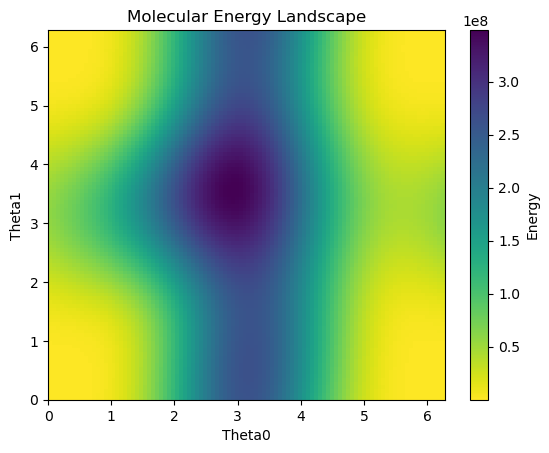

energies (1st row) [136.94836115439705, 271.26814569396316, 606.9161749636537, 1800.1644221733184, 6448.698202616382, 20432.056738306586, 53875.134473894635, 121091.96771312131, 241741.15381997952, 439958.896759766, 742938.9708619317, 1180776.3269584682, 1785791.29657124, 2591694.652023541, 3632743.8083231244, 4942883.911387223, 6554888.7919744635, 8499511.331476962, 10804670.655689063, 13494684.454031266, 16589567.725565448, 20104360.83939126, 24048591.754741013, 28425810.660481144, 33233200.130140122, 38461323.787521556, 44093987.68518553, 50108184.8951678, 56474236.77604409, 63155912.393101625, 70110798.8268235, 77290761.04185067, 84642370.14828472, 92107622.88791245, 99624600.99527213, 107128284.25331274, 114551397.02447413, 121825226.00183083, 128880732.88737766, 135649291.9136285, 142063777.12247455, 148059443.18077984, 153574878.0094, 158552857.44402027, 162941179.9626576, 166693440.777704, 169769602.79117617, 172136679.53953463, 173769196.00306386, 174649527.45564452, 174768133

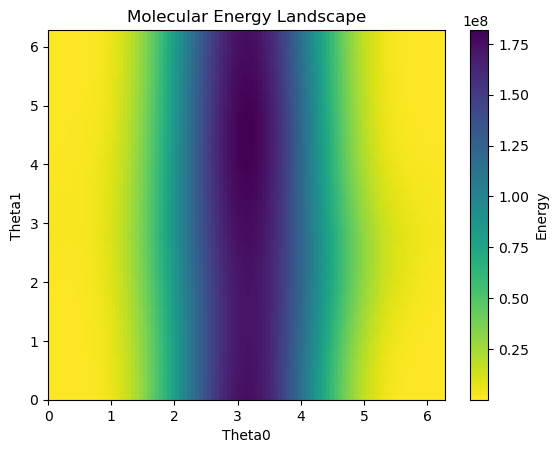

energies (1st row) [155.36240369013157, 291.3333737206437, 723.0816806891024, 2004.299316457559, 6206.028089783297, 17695.166671064795, 43047.38566352931, 91001.06179621276, 172509.48260754382, 300625.04931141896, 490256.6015715743, 757872.177426075, 1121107.8559519455, 1597874.7683767201, 2205105.972528536, 2960469.5675589717, 3884869.37645805, 4998050.946368441, 6300361.785321871, 7805874.356601138, 9525637.499026995, 11470934.12200547, 13648591.282556184, 16057314.929510145, 18693089.63925479, 21549082.490272515, 24615048.15752108, 27877158.046838902, 31318051.169102896, 34916916.86516644, 38649719.333176255, 42489451.35994578, 46406409.95011388, 50368593.578286126, 54342080.69828917, 58291497.60643987, 62180440.75937184, 65972012.38627015, 69629355.92954817, 73116094.01719163, 76396879.85515295, 79437934.20588216, 82207467.79808001, 84676212.06075032, 86817776.81816857, 88609090.84637065, 90030713.88289244, 91067089.73885486, 91706868.25387128, 91942965.02023989, 91772777.30934083,

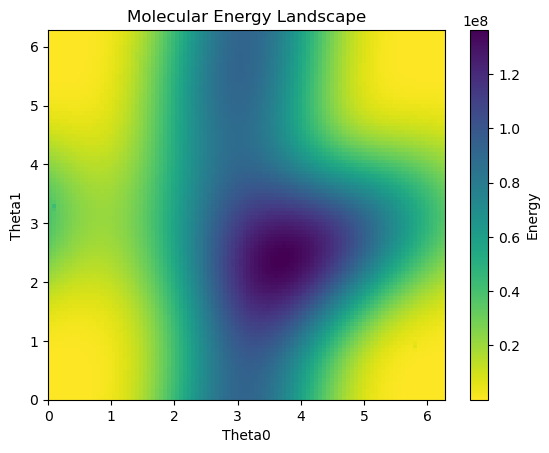

energies (1st row) [124.80941233365282, 336.8264430160849, 1075.6877194474607, 2462.9097950804335, 5598.395266280919, 13507.896316783877, 30094.751297778737, 60544.568356684525, 111888.89690774305, 191961.08225205922, 307052.03145800217, 470236.3518448272, 695158.6058895234, 993782.3982779897, 1378764.703582163, 1863066.9004020584, 2459391.059043518, 3179763.8452437813, 4035212.847553819, 5035458.024843173, 6188625.784451891, 7500969.810792054, 8976641.804626053, 10617501.255245056, 12422946.477498233, 14389812.284598887, 16512290.98151801, 18781912.71179098, 21187586.78048734, 23715647.12339328, 26349986.146893747, 29072231.704469744, 31861914.29806109, 34696742.90096165, 37552874.856546104, 40405210.24189014, 43227750.28217803, 45993910.35180019, 48676958.02592053, 51250300.556488164, 53687933.405448854, 55964746.98221169, 58056964.02319647, 59942439.4459085, 61600975.00646599, 63014657.86793024, 64168084.71971749, 65048606.47976784, 65646534.63180294, 65955235.81156577, 65971279.723

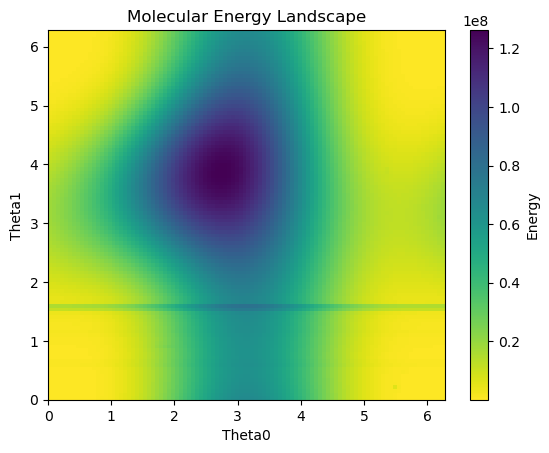

energies (1st row) [173.48516774784298, 574.92289575644, 1754.4320160649183, 4447.581197715769, 14482.181490210578, 44016.82816766382, 126717.7630251776, 235339.44146318483, 447687.9095636494, 799838.1368170321, 1337859.1099408718, 2101923.9132615323, 3150642.14392143, 4548701.300007939, 6353552.405469567, 8671209.179892415, 11415244.79798689, 14749252.164805124, 18720429.91726453, 23353653.378516525, 28682827.527454063, 34734250.60474893, 41524926.02453415, 49061766.54354851, 57340835.63054931, 66346961.371066466, 76053435.21648939, 86421909.9615543, 97402619.12778085, 108934566.98862667, 120946099.5438567, 133355685.49480703, 146072654.607369, 158998283.57434818, 172027081.11456358, 185047974.69710886, 197945831.3741271, 210602868.61377373, 222900448.79526284, 234720427.60869393, 245946885.68278307, 256467812.88595396, 266176567.66652653, 274973484.1711131, 282767125.1879076, 289475872.5713731, 295028799.0082622, 299366838.8184094, 302443634.8229559, 304226151.41446817, 304695251.650

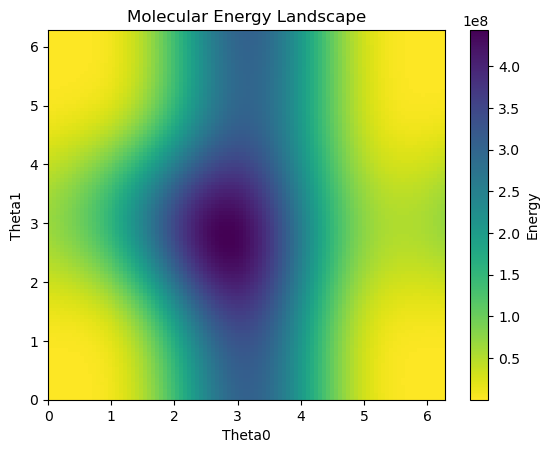

energies (1st row) [154.3381660772921, 229.42701065326793, 459.03450832615863, 1138.5230266439994, 4181.086787061039, 15416.04335554128, 45830.329527060334, 111820.33546048068, 234973.5746982206, 441615.34695766313, 762211.7709414604, 1230696.9918977586, 1883757.6784536808, 2760270.2350555817, 3904891.9608961293, 5357999.595817871, 7113494.837414821, 9291014.543404663, 12003616.162189877, 14851186.119333588, 18196539.59212968, 22083587.37800028, 26461950.56479844, 31330054.055188894, 36685952.3317169, 42518814.75511357, 48810863.26169327, 55537038.47329435, 62664826.09435323, 70154334.0395402, 77958656.80366898, 86024355.31167698, 94291989.16277127, 102696832.34622069, 111169666.58323559, 119637625.86009958, 128025172.44616666, 136255063.78463072, 144249468.43837804, 151930950.8345539, 159223554.61683398, 166053891.2140518, 172352188.237729, 178053248.0533587, 183097378.72671175, 187431348.6368885, 191008977.7489694, 193791944.26750192, 195750316.10284254, 196862959.23590556, 197117795

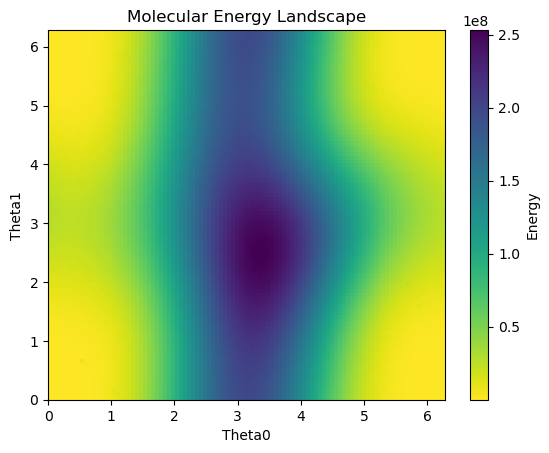

energies (1st row) [186.43596140681436, 325.184352092529, 713.7978711993751, 1703.2818661520537, 5119.960023974679, 14477.337536128194, 35506.22277730123, 76571.70468524322, 148671.54254393672, 265230.8295021647, 441809.4209443923, 695724.8613611638, 1045590.3954153812, 1510829.6582964477, 2111196.5559101417, 2866283.674115367, 3795020.878308161, 4915175.896421947, 6242880.465292272, 7792172.06907447, 9574586.298751924, 11598764.995038638, 13870128.509597007, 16390624.3057525, 19158474.69163551, 22168062.797861814, 25409823.701061007, 28870240.02615313, 32531907.487835437, 36373630.21144246, 40370632.77727036, 44494808.36494396, 48715036.81271384, 52997533.8509261, 57306293.34086984, 61603561.38973916, 65850281.830537766, 70006675.9835995, 74032790.33537985, 77888983.15127115, 81536573.55799052, 84938291.89961128, 88058928.51172149, 90865724.70107391, 93328915.13779281, 95422156.52050482, 97122911.71418232, 98412726.63852857, 99277584.18262303, 99708033.43110402, 99699408.60342245, 992

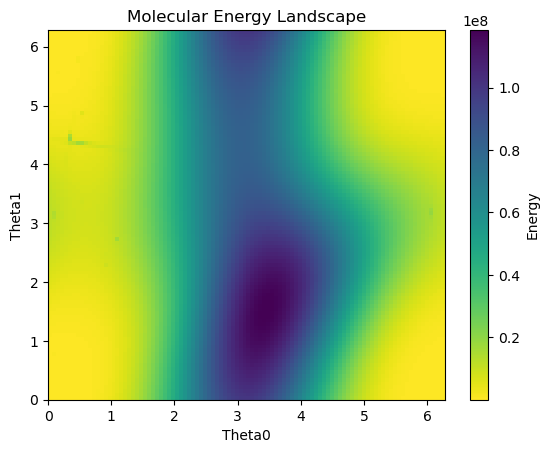

energies (1st row) [132.03143877321358, 381.9985931849758, 1081.4482455705336, 4508.090262351706, 17197.683057312686, 52081.938997488985, 130506.70858283131, 282524.62876601896, 546466.7792798689, 968033.3926056558, 1599495.0310297632, 2500234.069669054, 3745723.2387213307, 5391054.099734901, 7417999.909928648, 9984533.36283953, 13138820.342055432, 16926350.284665816, 21395655.250983767, 26604188.545925356, 32657630.655720666, 39324742.403078444, 46816606.236540444, 55157254.39654782, 64301686.3301451, 74226537.26169264, 84899482.90425357, 96276060.14035027, 108299628.91439988, 120901560.36296499, 134001908.73650095, 147510280.05361256, 161326699.11630493, 175342784.14559275, 189443164.3989734, 203506827.82462233, 217408712.88052797, 231021331.92263684, 244216636.43239436, 256867504.16579995, 268849659.3845083, 280043316.79948866, 290334954.3923088, 299618898.6226841, 307798648.21240264, 314788605.30199945, 320514879.3894661, 324916681.3673247, 327947063.42138994, 329573560.2152862, 32

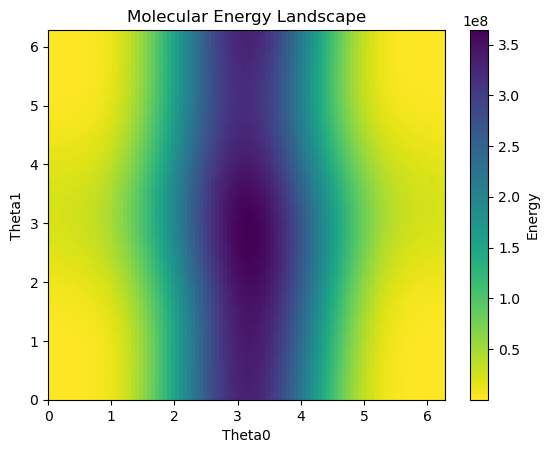

energies (1st row) [178.95741021606324, 293.18557103243717, 701.3940546400015, 2144.7855056027047, 6706.800857024398, 17981.901141520015, 41227.106805712676, 83421.62760790596, 153214.63276684575, 260798.1735630057, 417775.525025909, 636884.3714034428, 931579.7502708236, 1315764.6208486296, 1803615.6668148136, 2409070.62114754, 3144074.4872926245, 4019476.2946416033, 5047506.224805998, 6237625.380962628, 7596640.960546388, 9129358.277568707, 10838515.069855925, 12724865.054772204, 14783934.999770602, 17006126.326415416, 19387357.072691303, 21917560.8332695, 24581829.12362628, 27363173.132156875, 30242403.364445884, 33198181.551872857, 36207161.74743673, 39244291.3584903, 42283143.16779604, 45296224.211603224, 48255386.44153242, 51132187.55646579, 53898311.927109115, 56525930.59218304, 58988138.83250198, 61259312.89550304, 63315504.35729888, 65134763.85396427, 66697501.89673761, 67986755.28057145, 68988394.41392289, 69691423.2233653, 70088065.76565257, 70173917.60318418, 69948000.168743

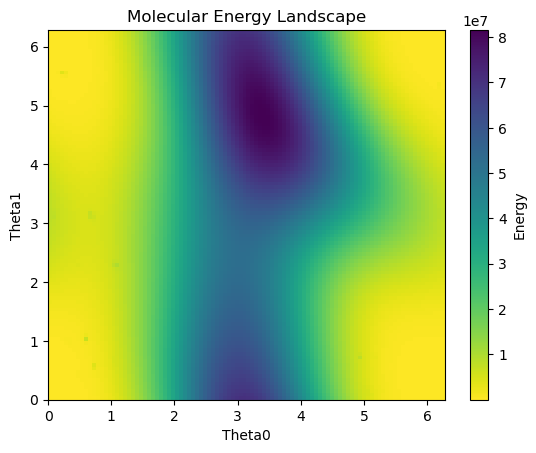

energies (1st row) [125.63509158213576, 293.8897803520397, 842.5327927428507, 2952.2728645764255, 10682.066333868113, 31508.307726353476, 76503.32752050657, 160535.28710664684, 302210.66932784946, 523601.45961631625, 849733.7069350147, 1308194.9184257954, 1929510.6909861767, 2749755.5371899903, 3793957.237492624, 5059923.493659516, 6609716.421206662, 8469966.54768866, 10655813.821208825, 13191787.387866583, 16095616.222944925, 19370474.192529403, 23018397.33299923, 27050327.19975676, 31460466.179073315, 36236368.84698446, 41360743.44914324, 46810613.33255289, 52557237.18557617, 58566213.073587775, 64797839.389763236, 71207539.3581359, 77746279.81111799, 84361267.96331736, 90996512.68317309, 97593608.85591356, 104092477.46025178, 110432141.67945127, 116551679.5693716, 122390910.36736083, 127891340.20866293, 132996912.26787932, 137654922.83192912, 141816649.2770898, 145438090.77768362, 148480685.7678837, 150911742.7619136, 152705031.7150405, 153841048.15084982, 154307431.81347826, 154099

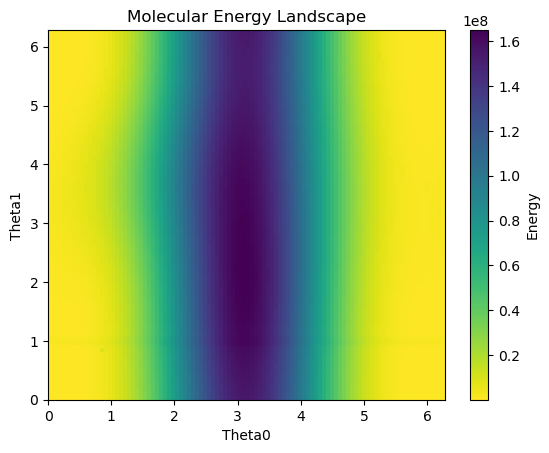

energies (1st row) [131.06923726339284, 230.62047885148442, 489.14203159274376, 840.7378413993528, 1463.848165847772, 2934.9050861666988, 6101.091584901251, 12120.632894364035, 22678.28264235295, 40075.22175263379, 66948.73279645247, 105696.58823276286, 159501.8197888213, 233172.9086461066, 331354.1794135892, 458204.1197986045, 617819.4761309259, 814237.9961760121, 1051308.1187883862, 1332547.9104467118, 1661012.700980343, 2039189.674584228, 2468913.533043526, 2951293.2676625517, 3486650.9403724372, 4074477.626326712, 4713400.735533281, 5401167.200675874, 6134648.879102377, 6909850.190786713, 7721944.183411817, 8565326.98359692, 9433668.381523453, 10319996.159354892, 11216782.989771022, 12116046.163408386, 13009452.333050372, 13888435.040500892, 14744327.769398093, 15568468.482399361, 16352338.782813262, 17087685.04300558, 17766644.028887626, 18381855.86797996, 18926573.896887586, 19394782.60755433, 19781256.044221804, 20081670.88715515, 20292645.149422064, 20411808.823017463, 20437813

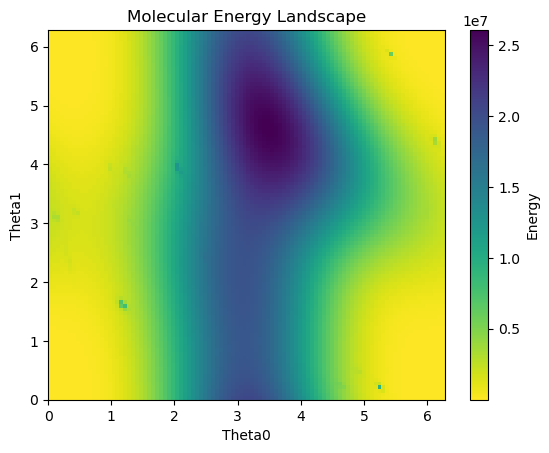

energies (1st row) [145.00802746635262, 493.3104833647619, 1842.8098444314155, 4876.970122242748, 16545.14692480107, 48019.20979584151, 116336.68193170927, 245351.40599367884, 464882.3574263654, 821019.6791888686, 1476724.2025769325, 2144365.9013281646, 3059372.109563963, 4370047.093761223, 6053979.279467765, 8108904.338871585, 10650894.218931923, 13706511.827164069, 17312237.342633978, 21503142.67321492, 26307869.162966836, 31747579.642369732, 37835162.90208291, 44574559.37296432, 51960147.03779036, 59976401.886740506, 68597699.89511636, 77788238.3161188, 87502308.08480415, 97684440.27326539, 108269981.59240928, 119185781.75062679, 130350906.77762431, 141677630.23250526, 153072475.22935998, 164437423.0064974, 175671182.6911507, 186670410.14163107, 197331389.69723, 207551095.08956474, 217228838.54875314, 226267572.20999244, 234575335.96785605, 242066526.23756438, 248662994.85695195, 254295446.93518344, 258904156.60470897, 262439954.67194673, 264864938.40352985, 266153009.159274, 266290

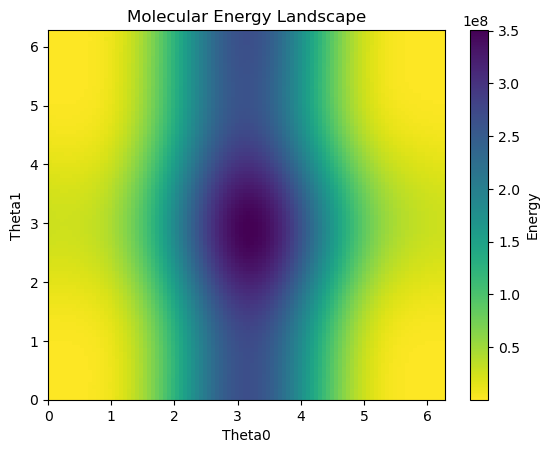

energies (1st row) [134.55209403955817, 218.5830051871899, 509.0436496757436, 1806.587667782471, 6979.628718701391, 21854.07894616961, 55594.85506104376, 120750.29110012997, 233077.7535026856, 411218.6762561819, 676266.1728211159, 1051254.3327271806, 1560591.2753107075, 2229451.6105393353, 3083151.3853226625, 4146520.7536952635, 5443295.513841722, 6995530.819553957, 8822772.90206047, 10940923.543489203, 13363014.816204216, 16099217.03996763, 19154782.99174494, 22530082.393797576, 26220712.342146408, 30217348.763479907, 34505641.45752682, 39066196.88883845, 43874732.90451341, 48902190.80014031, 54115068.59540287, 59475753.21260004, 64942962.69657518, 70472208.33173983, 76016399.55925255, 81526419.28563577, 86951788.45981747, 92241316.47284003, 97343905.57672508, 102209100.75083393, 106787914.4441857, 111033499.86025286, 114901790.68694341, 118352154.73664229, 121347980.30868116, 123857234.33603798, 125852854.43466552, 127313210.36026068, 128222402.25306489, 128570485.67571148, 128353648

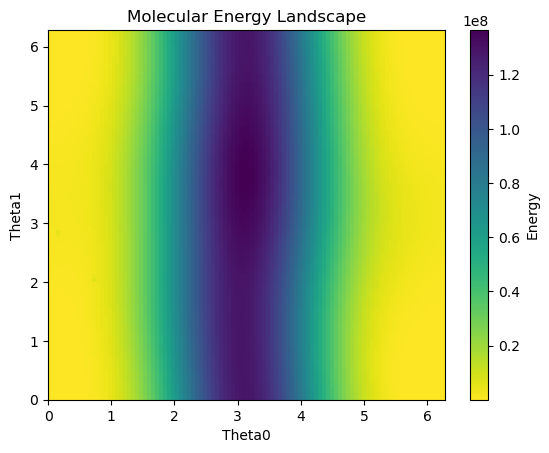

energies (1st row) [150.27817469702097, 317.77231428274627, 878.1337088646441, 3168.184468461765, 11687.348684979363, 35441.14621834256, 102903.0406949109, 1097306.9569122612, 413406.23047520325, 581684.4360067893, 940578.7185031412, 1448099.0166039264, 2134186.7054989305, 3031496.779688819, 4172945.3413354894, 5590786.002927791, 7315756.510729872, 9376254.750244446, 11797579.134260079, 14601192.80170264, 17804081.182797767, 21418136.04047406, 25449677.0406369, 29899040.884932674, 34760262.44313233, 40020884.412486926, 45661856.133203216, 51657573.29627823, 57976044.979437694, 64579084.78981351, 71422691.63853921, 78457563.46636938, 85629604.3761291, 92880594.92963538, 100148899.86546314, 107370296.1126555, 114478809.100145, 121407557.72286297, 128089785.96749048, 134459630.70939985, 140453144.998066, 146009164.1341176, 151070222.73447317, 155583328.95209628, 159500724.4847196, 162780650.7914149, 165387828.2077788, 167294104.80489397, 168478761.03189173, 168928910.92012748, 168639558.9

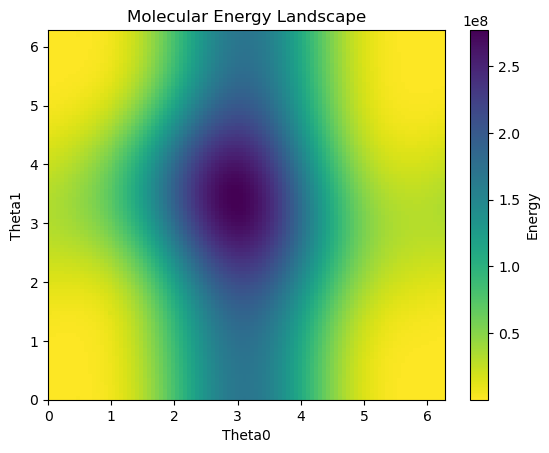

energies (1st row) [149.3886994744091, 415.73929336785403, 1429.5616544101078, 3534.2476910029277, 9509.73100475624, 25728.0295379164, 60635.776481743684, 126252.97935194364, 238746.9298636977, 413416.6084265183, 669812.2238161863, 1036056.5662727469, 1536697.9804202847, 2197253.9074346144, 3044062.9447319293, 4103269.7131285174, 5400185.097407252, 6958639.335775474, 8800214.58964388, 10943566.422991287, 13403923.277127942, 16192604.404258661, 19316585.758760925, 22778178.63555705, 26574705.937332496, 30698285.027328875, 35135745.6787993, 39868580.7324389, 44873088.26112345, 50120446.06745285, 55577035.866099805, 61204783.003823034, 66961540.47161886, 72801597.06995305, 78676269.56237234, 84534479.63949813, 90323462.34423712, 95989432.08477844, 101478379.44119823, 106736714.56915046, 111712114.1074753, 116354174.79895978, 120615212.75225163, 124450861.66508009, 127820777.70334548, 130689211.31716196, 133025465.75330897, 134804414.62038583, 136006832.2731234, 136619704.07863674, 1366363

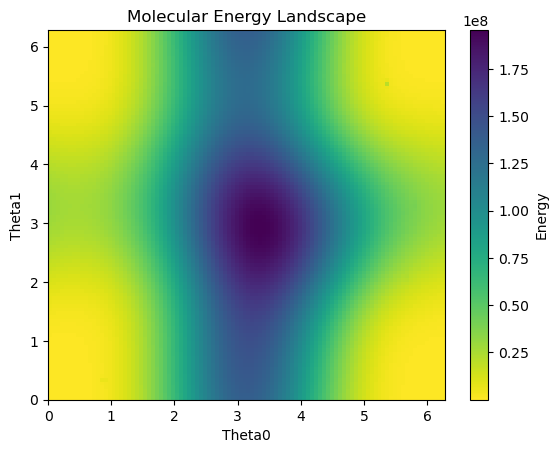

energies (1st row) [146.71870124784536, 300.5247582316859, 803.5059391972231, 1884.5090560268375, 4548.0418369665695, 11276.906591199162, 26027.42632407949, 54054.05201228396, 101853.93383199736, 177202.77723005557, 289077.23277859826, 447467.24894876604, 663123.4339490845, 947179.821771798, 1310684.360992744, 1764589.9427972848, 2320001.8627393334, 2987480.4715770655, 3776317.990297941, 4694409.705480668, 5748191.186538575, 6942478.512951916, 8280315.13855688, 9762945.887414077, 11389812.385883288, 13156921.338444045, 15053873.414896913, 17072367.819141164, 19206383.725411452, 21443608.13424456, 23768442.668879062, 26163772.986165285, 28610992.678402625, 31090081.67158968, 33579792.24482759, 36057904.45183202, 38501518.81679909, 40887361.150149845, 43192130.434878945, 45392777.9902511, 47466883.792203166, 49392947.83779402, 51150710.09380215, 52721463.04296519, 54088286.73182382, 55236352.10546938, 56153087.563086465, 56828395.69507286, 57254801.37610819, 57427550.85876045, 57344696.2

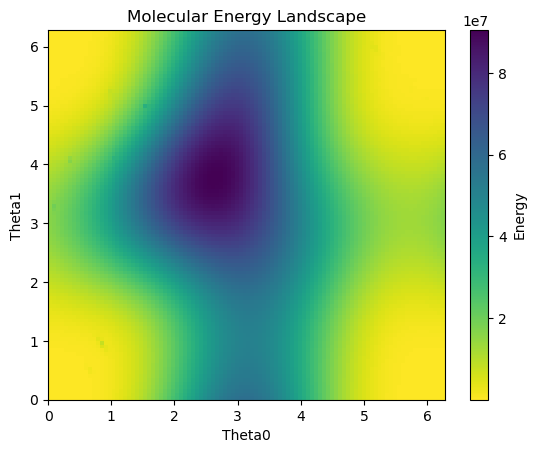

energies (1st row) [208.82747484316928, 309.169525020857, 632.4204127003165, 1643.1556748235737, 5112.654293008143, 14688.74507408996, 35936.58393649589, 76293.97256896606, 145040.52643089526, 253167.99449727958, 413149.799524837, 638646.7815337153, 944175.4702497692, 1344752.9990316443, 1855530.6791175636, 2491476.6768017667, 3267587.537160301, 4205446.298115987, 5465680.9182508215, 7195883.498748159, 8042359.811949141, 9634684.440320635, 11455510.26890443, 13469715.68241803, 15672065.703532286, 18056513.83831666, 20614203.349224754, 23333284.645425353, 26198963.505713843, 29193595.979354583, 32296854.69356194, 35485966.44549085, 38735969.792712346, 42019991.21353463, 45309622.570077166, 48575283.77134359, 51786619.791574255, 54912884.595293194, 57923444.829403326, 60788118.86206355, 63477668.45195768, 65964190.95714141, 68221542.55005714, 70225683.11320773, 71955068.84780036, 73390952.10380875, 74517646.56088212, 75322781.28352489, 75797461.97659901, 75936396.56089692, 75738030.92311

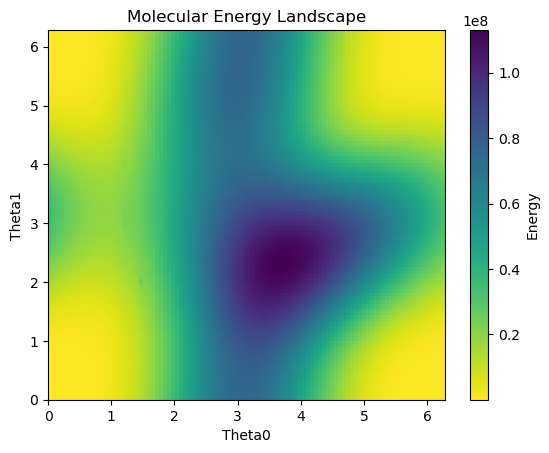

In [15]:
ix_smi = 0
datapoint = dataset.datapoints[ix_smi]
data = copy.deepcopy(datapoint)
for ix in range(len(conformers_gen[datapoint.canonical_smi])): # for each different values of bond lenghts and angles from generated data
    #data.pos, data.weights = datapoint.pos[ix], datapoint.weights[ix]
    data.pos, data.weights  = conformers_gen[datapoint.canonical_smi][ix].GetConformer().GetPositions(), None
    data.mol = conformers_gen[datapoint.canonical_smi][ix]
    energy_landscape = get_2dheatmap_array(data, 1, 3)
    print('energies (1st row)', energy_landscape[0])
    #plot heatmap
    plt.figure()
    plt.imshow(energy_landscape, extent=[0, 2 * np.pi, 0, 2 * np.pi], origin='lower', aspect='auto', cmap='viridis_r')
    plt.colorbar(label='Energy')
    plt.xlabel('Theta0')
    plt.ylabel('Theta1')
    plt.title('Molecular Energy Landscape')
    plt.show()


In [6]:
ix_smi = 0
datapoint = dataset.datapoints[ix_smi]

In [9]:
ix_smi = 100
datapoint = dataset.datapoints[ix_smi]
data = copy.deepcopy(datapoint)
gt_energies = []
for ix in range(len(data.pos)): # for each different values of bond lenghts and angles from ground truth data
    data.pos, data.weights = datapoint.pos[ix], datapoint.weights[ix]
    mol = pyg_to_mol(data.mol, data, mmff=False, rmsd=True, copy=True)
    gt_energies.append(mmff_energy(mol))
gt_energies

[88.48363572117384,
 102.57827266842412,
 92.88099674808367,
 120.63468969203186,
 93.61293971330171,
 102.36861901879635,
 93.00142878722747,
 99.95935976630645,
 96.85953790321688,
 103.41055987809045,
 115.91545611156239,
 114.83316363650722,
 94.05107813364317,
 93.11324150714222,
 101.50254539046314,
 91.07663369391834,
 98.12714920819069,
 117.42779615646423,
 105.7238078488195,
 92.03733160814811,
 91.00584618978115,
 107.34212369569305,
 101.23852476304451]

energy gt optimized  4.158712901987723
energies (1st row) [83.2604062304047, 83.50843386314855, 83.77875576736162, 84.06747894608884, 84.37034818506103, 84.6827887508783, 85.00003542275826, 85.31715483706128, 85.62913621269857, 85.93104087720175, 86.21800049974291, 86.48539079264168, 86.72883761756952, 86.94441470339672, 87.12859964599576, 87.27838583643785, 87.39138100831659, 87.46578338708136, 87.50046661365823, 87.49498377411953, 87.44954889735465, 87.36508542615425, 87.24318564130442, 87.08604271512448, 86.89647850554397, 86.67782378430033, 86.43388973448924, 86.16887332924367, 85.88727820512736, 85.59387301270581, 85.29350591975481, 84.99111037498767, 84.6915347607353, 84.39948372563461, 84.11948378567925, 83.855712392221, 83.61202334392257, 83.39186473441285, 83.198223497438, 83.03365784235362, 82.90026238419719, 82.79966659198575, 82.73300118565612, 82.7010036596445, 82.70391392349515, 82.74156206053891, 82.81331668993798, 82.91808981250315, 83.05432843536255, 83.21999079005386,

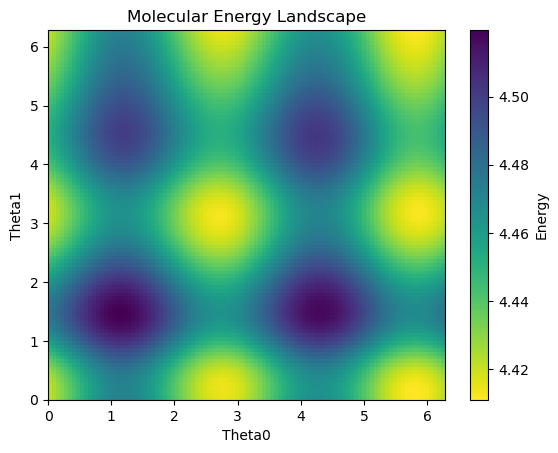

energy gt optimized  4.160683474898338
energies (1st row) [93.29684317587014, 93.50675405219688, 93.73949427518998, 93.99191091365263, 94.26044590834239, 94.54113710528607, 94.82969702627811, 95.12156150555414, 95.411997037266, 95.69619932504007, 95.96934972915365, 96.22672019988359, 96.46383245707493, 96.67646216669219, 96.86078080656166, 97.01339592007282, 97.13149456062625, 97.21279489401176, 97.25565894885936, 97.25913783210116, 97.22294370755434, 97.14746873567107, 97.03380644172977, 96.88370419530246, 96.69954318851855, 96.48429424648764, 96.24141523914652, 95.97487000757722, 95.68894532370079, 95.38828438102426, 95.07771627489741, 94.76214722392449, 94.44655603693478, 94.13580930460462, 93.83465707480686, 93.54756939160994, 93.27871109450264, 93.0319164334493, 92.81054985861597, 92.61756271172588, 92.45542089346436, 92.32614876822025, 92.23128208070078, 92.1718445489959, 92.14842800944014, 92.16119555722368, 92.2098235902442, 92.2934750825175, 92.41090168549117, 92.560368793943,

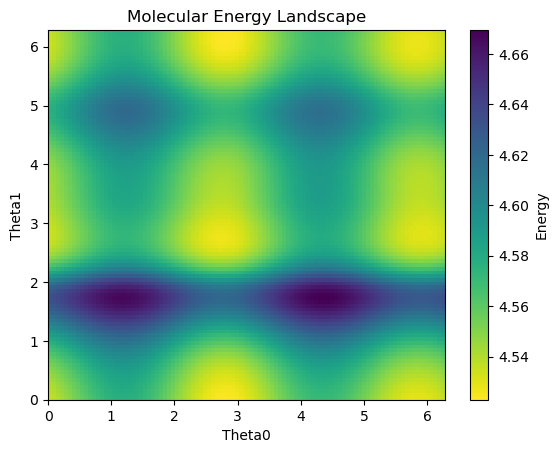

energy gt optimized  4.1606834749733315
energies (1st row) [94.53855408388449, 94.68094757538506, 94.85474460543776, 95.05795982561133, 95.2880625630491, 95.5421461337045, 95.81680270781482, 96.10822341266791, 96.41222470366105, 96.72432093416671, 97.03976705982464, 97.35367967575533, 97.66108590630782, 97.95704600203962, 98.23673767408545, 98.49555920830699, 98.72920475015184, 98.93376899439596, 99.10581642058938, 99.2424336428137, 99.3413116616895, 99.40076964506775, 99.41980886112145, 99.39810273586596, 99.33603831996757, 99.23468614859013, 99.09577723577462, 98.92165578754609, 98.71531243818563, 98.48020400168105, 98.22028845236812, 97.93989935956586, 97.64363558718159, 97.33634509086886, 97.0229857065641, 96.70849114275663, 96.39776619109892, 96.09552604665578, 95.80623175127238, 95.5340650307439, 95.28277796231737, 95.05575353741656, 94.85590171865456, 94.68567365104462, 94.54706462897283, 94.44161433380745, 94.37036838539697, 94.33400579500966, 94.33269063971278, 94.366203863545

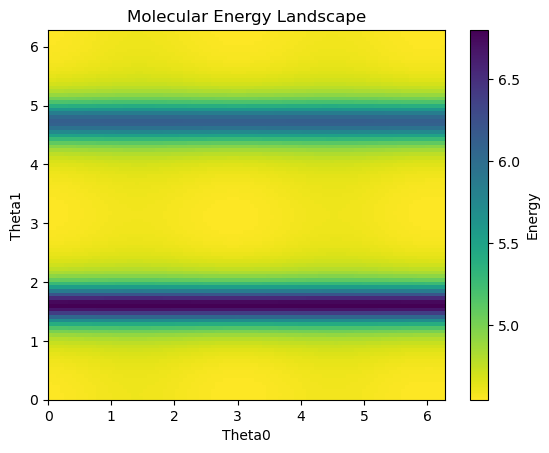

In [26]:
ix_smi = np.randon.randint(0, len(dataset.datapoints))

datapoint = dataset.datapoints[ix_smi]
data = copy.deepcopy(datapoint)
for ix in range(len(data.pos)): # for each different values of bond lenghts and angles from ground truth data
    data.pos, data.weights = datapoint.pos[ix], datapoint.weights[ix]
    print('energy gt optimized ', np.log(mmff_energy(pyg_to_mol(data.mol, data, mmff=True, rmsd=True, copy=True))))
    energy_landscape = get_2dheatmap_array(data,ix0=0, ix1=2)
    #plot heatmap
    plt.figure()
    plt.imshow(np.log(energy_landscape), extent=[0, 2 * np.pi, 0, 2 * np.pi], origin='lower', aspect='auto', cmap='viridis_r')
    plt.colorbar(label='Energy')
    plt.xlabel('Theta0')
    plt.ylabel('Theta1')
    plt.title('Molecular Energy Landscape')
    plt.show()

## to dos: 
- plot the rotatable bonds with a different color

bond lengths tensor([1.1095, 1.0911, 1.1190, 1.5132, 1.4908, 1.4897, 1.1350, 1.1293, 1.1081,
        1.1235, 1.1131, 1.1281, 1.4894, 1.4383, 1.4963, 1.1280, 1.4429, 1.0413,
        1.6360, 1.4223, 1.4299, 1.4271, 1.2573, 1.4735, 1.1273, 1.1296, 1.3819,
        1.3759, 1.3678, 1.0887, 1.3841, 1.0922, 1.3712, 1.0884, 1.3976, 1.0702,
        1.0637])
energies (1st row) [18.13515986482678, 18.081787737452817, 18.01985181613158, 17.95542311111608, 17.8943903452864, 17.84191628823253, 17.801977480076676, 17.777019819092562, 17.767792467852264, 17.773369368287593, 17.791309511159785, 17.818064124129894, 17.84954383562344, 17.88182426464228, 17.911840425409896, 17.937970097250872, 17.960305923449955, 17.9806390514152, 18.00200091475462, 18.028021808086795, 18.062127359721774, 18.1067800430602, 18.162974504491604, 18.22997398492787, 18.305386267173862, 18.385484245902166, 18.4657343962344, 18.541409726203756, 18.60819156373798, 18.662711918282714, 18.702924861370082, 18.728293822032402, 18.7397

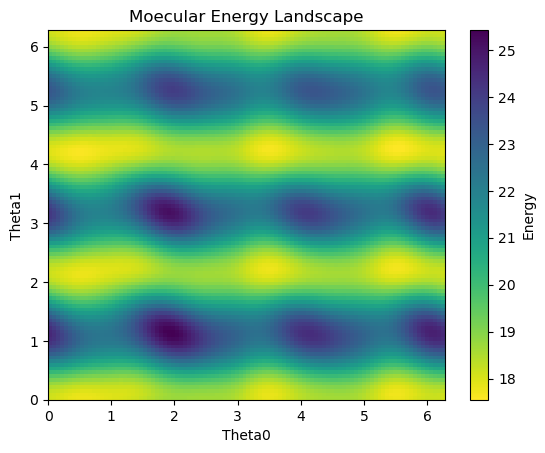

bond lengths tensor([1.1008, 1.1213, 1.1232, 1.5058, 1.5155, 1.5001, 1.1057, 1.1199, 1.1127,
        1.1078, 1.1225, 1.1080, 1.5143, 1.4329, 1.4779, 1.0941, 1.4166, 1.0324,
        1.6397, 1.4281, 1.4210, 1.4313, 1.2722, 1.4845, 1.1259, 1.1240, 1.3811,
        1.3844, 1.3804, 1.0906, 1.3787, 1.0868, 1.3786, 1.0960, 1.3885, 1.0883,
        1.0753])
energies (1st row) [28.42151067222778, 28.633263909289834, 28.931314176007017, 29.30609983542841, 29.746203847473144, 30.238454016012785, 30.767956817454255, 31.318216537718392, 31.871263688723804, 32.40793703067423, 32.90830765043411, 33.3523678878864, 33.7209104279533, 33.9966426341453, 34.165426312064085, 34.21748060508665, 34.14837659783868, 33.959671853880025, 33.65898980054769, 33.25962211602078, 32.77956388887215, 32.24028930355165, 31.665276443437666, 31.078602661750146, 30.50364922912775, 29.9620619647981, 29.472957622573386, 29.052440822332297, 28.713336923019366, 28.465130112455565, 28.314063510584557, 28.263303812838696, 28.313207

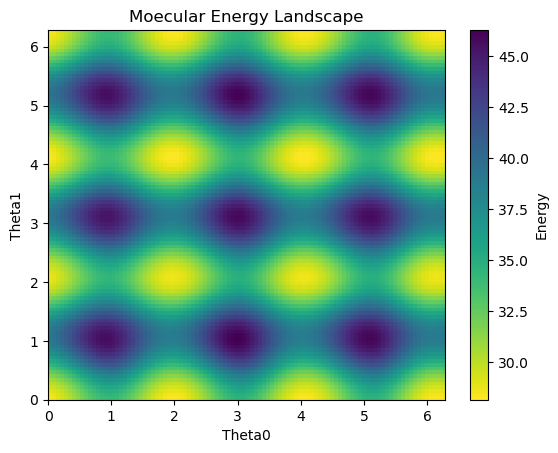

bond lengths tensor([1.1179, 1.1075, 1.1114, 1.5279, 1.4947, 1.5062, 1.1274, 1.1097, 1.1194,
        1.1151, 1.1092, 1.1095, 1.5059, 1.4497, 1.5040, 1.0839, 1.4224, 1.0410,
        1.6535, 1.4230, 1.4329, 1.4488, 1.2372, 1.4888, 1.1185, 1.1093, 1.3968,
        1.3797, 1.3676, 1.0700, 1.3747, 1.0854, 1.3659, 1.0971, 1.3779, 1.0854,
        1.0685])
energies (1st row) [166.62121150086557, 166.9946870201693, 167.4094268033025, 167.85104352340147, 168.30357572650695, 168.75007163662752, 169.17331051782298, 169.55661906412598, 169.8847338923776, 170.1445944678606, 170.32606569679632, 170.42243305879612, 170.43070302353146, 170.35161004373367, 170.18942687584826, 169.9515833040125, 169.64811644636723, 169.29113831180433, 168.8942067930484, 168.47180985506662, 168.03881303079913, 167.61003926130144, 167.19983143880654, 166.82170772721355, 166.48803920909103, 166.20973315435305, 165.99601183611838, 165.85415005408703, 165.7892965700063, 165.80429901999213, 165.89955320737408, 166.0728913747619

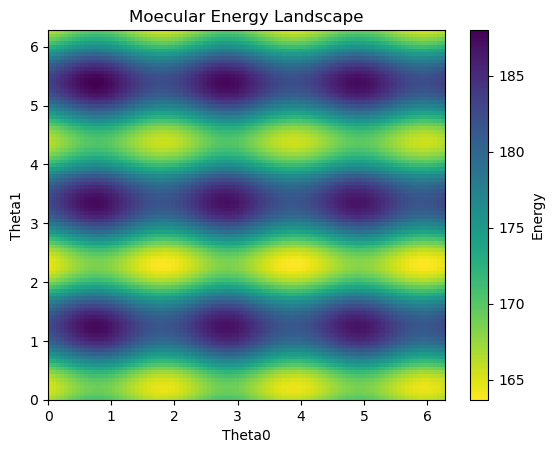

bond lengths tensor([1.0960, 1.1137, 1.1110, 1.5275, 1.5038, 1.4916, 1.1113, 1.1249, 1.1196,
        1.1217, 1.1107, 1.1075, 1.4966, 1.4164, 1.5077, 1.1051, 1.4148, 1.0301,
        1.6498, 1.4290, 1.4143, 1.4500, 1.2409, 1.4826, 1.0982, 1.1215, 1.3770,
        1.3805, 1.3950, 1.0820, 1.3732, 1.0689, 1.3690, 1.0824, 1.3934, 1.0843,
        1.0896])
energies (1st row) [15.388160002528831, 15.477136215005498, 15.668623230260504, 15.958946829562688, 16.342219418953036, 16.810061628949526, 17.35136642890826, 17.95198061505904, 18.594554025687255, 19.258465768916533, 19.920102767808896, 20.55344479313423, 21.131176103622902, 21.62620013074385, 22.01360843158206, 22.272754660173877, 22.38921567798774, 22.356280523087197, 22.17564596789406, 21.857245551802716, 21.418227627881347, 20.88127422517753, 20.272619104125095, 19.620037329386843, 18.951050197650698, 18.29155662433673, 17.66487918707868, 17.091183310680393, 16.587284510173518, 16.166650466580407, 15.83959080030682, 15.613496985773235, 1

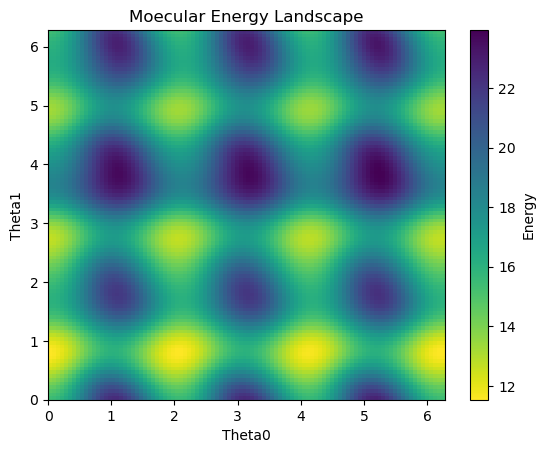

bond lengths tensor([1.1116, 1.0990, 1.1080, 1.5309, 1.5106, 1.5101, 1.1023, 1.1091, 1.1101,
        1.0911, 1.1029, 1.1106, 1.4943, 1.4467, 1.4703, 1.1108, 1.4215, 1.0467,
        1.6556, 1.4214, 1.4109, 1.4612, 1.2540, 1.4724, 1.1083, 1.1147, 1.3703,
        1.3881, 1.3839, 1.0834, 1.3622, 1.0899, 1.3819, 1.0983, 1.3784, 1.0910,
        1.0697])
energies (1st row) [98.16285419872935, 98.12685115220398, 97.98133167303968, 97.73098883389486, 97.38601570480031, 96.96150058099764, 96.47644810099317, 95.95247052786239, 95.41233894937979, 94.87864452731343, 94.37259201795884, 93.91311654491172, 93.51621907785763, 93.19462707879389, 92.95765241297859, 92.81123648375917, 92.75809198736887, 92.79796173572034, 92.9278863466346, 93.14246593245811, 93.4341407838419, 93.79341545382091, 94.20905136139011, 94.6682485058207, 95.15680566724068, 95.65928907132782, 96.15925646360168, 96.63954968220295, 97.08270266150046, 97.47150521339086, 97.78973028611279, 98.0229917597656, 98.15970687140731, 98.1920

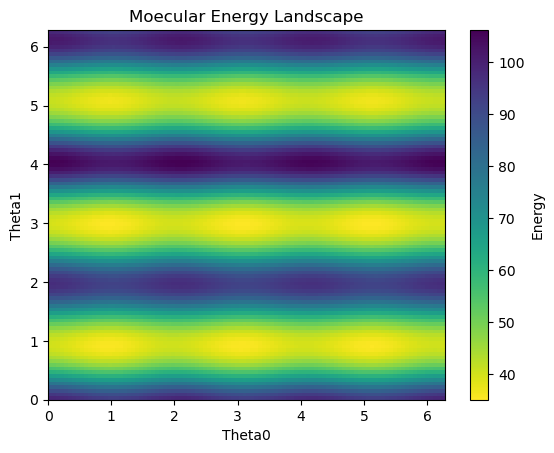

bond lengths tensor([1.1119, 1.1213, 1.1021, 1.5100, 1.5164, 1.5083, 1.1029, 1.1156, 1.1135,
        1.1072, 1.1125, 1.0907, 1.5271, 1.4614, 1.4874, 1.0856, 1.4273, 1.0276,
        1.6518, 1.4224, 1.4252, 1.4563, 1.2455, 1.4841, 1.1071, 1.1298, 1.3776,
        1.3798, 1.3968, 1.0864, 1.3775, 1.0703, 1.3665, 1.1023, 1.3919, 1.0679,
        1.0788])
energies (1st row) [26.55727428451261, 25.149742013476676, 23.99006059064252, 23.090165625962022, 22.447642377074963, 22.050897164282638, 21.88334576859659, 21.926425586267946, 22.16171858173424, 22.572317644377982, 23.143644595277188, 23.86381271324411, 24.72364818692214, 25.716202293400478, 26.835772567690647, 28.07611284577908, 29.42759846099365, 30.873368578634512, 32.38450124283958, 33.91494029561598, 35.39784269294358, 36.74517669972115, 37.85295899751119, 38.613119960290554, 38.93145098989714, 38.7469360110856, 38.04732909022277, 36.87510306752112, 35.321256139025785, 33.50925634394671, 31.57392315867154, 29.642152696969205, 27.8189922

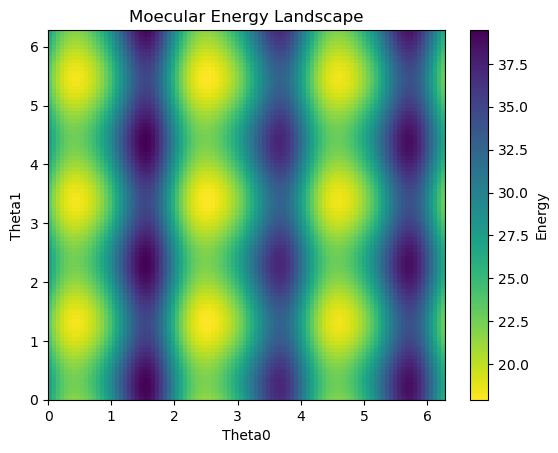

bond lengths tensor([1.0961, 1.1128, 1.1146, 1.5148, 1.4874, 1.4847, 1.1349, 1.0988, 1.1305,
        1.1297, 1.1045, 1.1307, 1.4838, 1.4260, 1.4963, 1.1088, 1.4341, 1.0553,
        1.6518, 1.4217, 1.4217, 1.4649, 1.2688, 1.4695, 1.1139, 1.1177, 1.3676,
        1.3626, 1.3992, 1.0664, 1.3758, 1.0635, 1.3813, 1.0874, 1.3904, 1.0654,
        1.0688])
energies (1st row) [16.725947211446453, 16.78717007921273, 16.936537591746543, 17.170464387942616, 17.483073595251682, 17.866330168409874, 18.310133142225723, 18.802347786724297, 19.328863139535528, 19.873691418411667, 20.419116138727013, 20.945969320510322, 21.43417808432139, 21.86347938783748, 22.214489552109562, 22.469936027583508, 22.61604968343112, 22.643901461311906, 22.550375619687138, 22.338769375200563, 22.01856183641376, 21.604753339931136, 21.116567864857608, 20.575903731900347, 20.005804503129653, 19.428995607376592, 18.866794774471643, 18.33827281971189, 17.8598460711343, 17.444951648798565, 17.104063020252, 16.844679529178308, 1

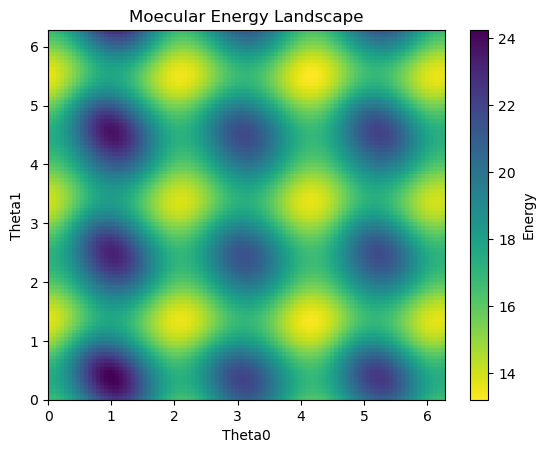

bond lengths tensor([1.1043, 1.1130, 1.1082, 1.5353, 1.5139, 1.4999, 1.0873, 1.1163, 1.0957,
        1.1180, 1.1085, 1.1114, 1.4943, 1.4119, 1.4852, 1.1217, 1.4169, 1.0272,
        1.6460, 1.4319, 1.4188, 1.4591, 1.2665, 1.4917, 1.0946, 1.1172, 1.3768,
        1.3774, 1.3725, 1.1001, 1.3640, 1.0961, 1.3756, 1.0831, 1.3793, 1.0833,
        1.0978])
energies (1st row) [20.47365324376528, 20.137212925953744, 19.76414535139892, 19.366882666139997, 18.959047692190847, 18.555016384756396, 18.16939070986498, 17.816436113242016, 17.50945588674531, 17.26019748457389, 17.078308459094835, 16.970841418294718, 16.941928679512777, 16.992539573243384, 17.120423787407386, 17.320189960847156, 17.583561869990657, 17.89977199253627, 18.256097895055515, 18.638447599081086, 19.032038378093585, 19.42208228619158, 19.794339960389177, 20.13567679524891, 20.43445948695418, 20.68085003046198, 20.866943861804142, 20.986900651163094, 21.036994983418932, 21.01557803648566, 20.9231543180974, 20.76233371885615, 20.5

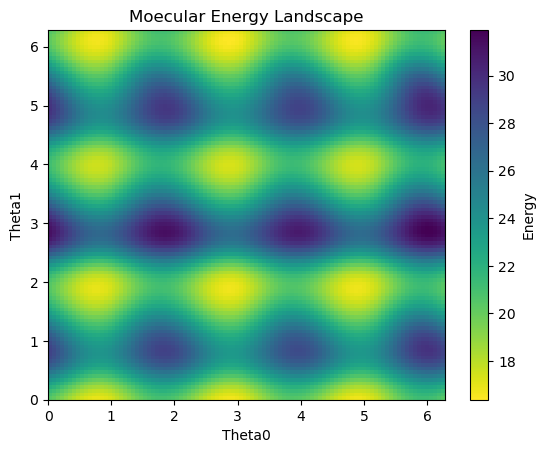

bond lengths tensor([1.1159, 1.0910, 1.1159, 1.5304, 1.5247, 1.4940, 1.1068, 1.0977, 1.1077,
        1.1304, 1.0907, 1.1213, 1.5042, 1.4357, 1.4650, 1.1242, 1.4075, 1.0547,
        1.6509, 1.4214, 1.4185, 1.4420, 1.2552, 1.4895, 1.1256, 1.1199, 1.3801,
        1.3865, 1.3832, 1.0994, 1.3783, 1.0804, 1.3782, 1.0881, 1.3788, 1.0901,
        1.0947])
energies (1st row) [16.333371174401027, 16.62199895035558, 16.98494700691875, 17.411405343354136, 17.8885222948678, 18.40173618815105, 18.935080845064437, 19.471554327236998, 19.99352558935539, 20.48314025407709, 20.922837942903506, 21.29590088113013, 21.587089676422302, 21.783342352547344, 21.874650049688647, 21.854860914814374, 21.722448828187403, 21.480997520285634, 21.13943632276294, 20.71168540786187, 20.21588474800551, 19.673271132081165, 19.10685880343433, 18.53999961405177, 17.995160703929105, 17.492959144241386, 17.051388357841038, 16.6853945113366, 16.40658256863073, 16.223131665725422, 16.13975199825092, 16.157765428610464, 16.2751

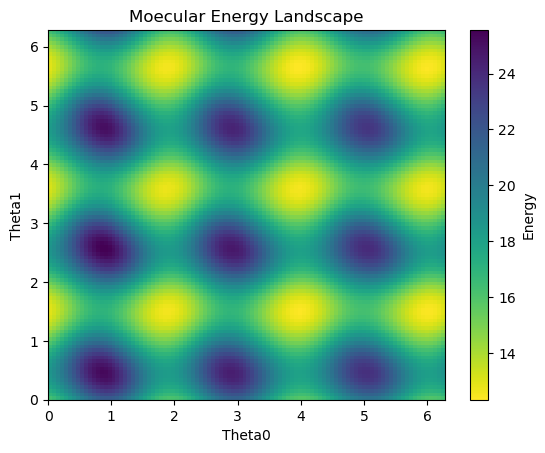

bond lengths tensor([1.1141, 1.1049, 1.1442, 1.4841, 1.5353, 1.4770, 1.1317, 1.1115, 1.1113,
        1.1055, 1.1396, 1.1462, 1.4694, 1.4273, 1.5077, 1.1245, 1.4393, 1.0322,
        1.6432, 1.4182, 1.4303, 1.4239, 1.2449, 1.4799, 1.1105, 1.1109, 1.3787,
        1.3786, 1.3951, 1.0697, 1.3883, 1.0785, 1.3794, 1.0815, 1.3809, 1.0820,
        1.0731])
energies (1st row) [25.953086914068844, 25.88902470357368, 25.910465555915987, 26.017853098776197, 26.208351308711112, 26.47578960832079, 26.810749647369118, 27.200829328789805, 27.6310786632237, 28.08462397919934, 28.543442546862483, 28.989211576301717, 29.404248209474137, 29.772401787651763, 30.0797980232549, 30.315495437311792, 30.47183954962213, 30.544631588643337, 30.53304179675231, 30.43936267879172, 30.26866587661605, 30.028358579055737, 29.72777010203035, 29.37772026186511, 28.990226521985054, 28.578165462738216, 28.155006685357595, 27.73454528706507, 27.330641141856812, 26.956878221878423, 26.626218357799385, 26.350584171651118, 26.1

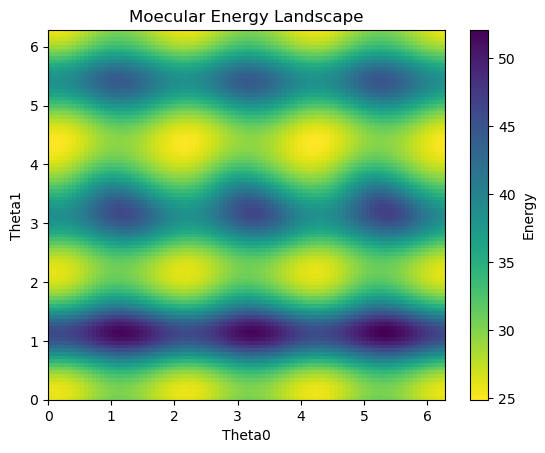

bond lengths tensor([1.1094, 1.1094, 1.1156, 1.5125, 1.5361, 1.5008, 1.0863, 1.1297, 1.0907,
        1.1066, 1.1011, 1.1130, 1.4881, 1.4681, 1.4907, 1.0975, 1.4219, 1.0431,
        1.6318, 1.4424, 1.4401, 1.4319, 1.2557, 1.4919, 1.1009, 1.1245, 1.3637,
        1.3845, 1.3855, 1.0846, 1.3935, 1.0715, 1.3915, 1.0762, 1.3766, 1.0877,
        1.0830])
energies (1st row) [41.58650935296881, 41.46416305500244, 41.45639437928213, 41.557407583273424, 41.75885751802808, 42.05026841017549, 42.41919823866811, 42.851494840932865, 43.33140254857732, 43.84179139411028, 44.364313605371464, 44.87969137349184, 45.36816979902345, 45.81001244064522, 46.186270661616, 46.4796965986393, 46.67571761932562, 46.7635610889351, 46.73721047493252, 46.59604070092963, 46.34519972440621, 45.99536463460766, 45.56210423775338, 45.06477297761539, 44.52522914846243, 43.966464837524, 43.41130369625619, 42.88135672864339, 42.396170853975455, 41.97266707911207, 41.624765403528265, 41.36321187946592, 41.19546231019305, 41.1

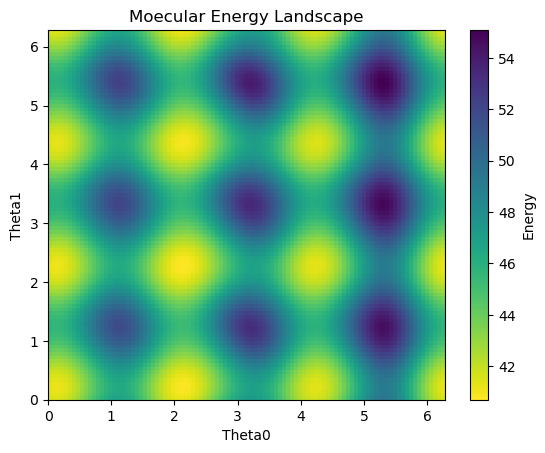

bond lengths tensor([1.1066, 1.1108, 1.1035, 1.5262, 1.5214, 1.4945, 1.1046, 1.1063, 1.1030,
        1.1116, 1.1156, 1.1073, 1.4977, 1.4718, 1.4683, 1.1008, 1.4215, 1.0485,
        1.6341, 1.4127, 1.4224, 1.4297, 1.2581, 1.4651, 1.1205, 1.1140, 1.3768,
        1.3782, 1.3666, 1.0965, 1.3791, 1.1009, 1.3785, 1.0983, 1.3779, 1.0878,
        1.0985])
energies (1st row) [16.67313513453393, 16.056501774749087, 15.4035851477691, 14.749531378702649, 14.129032501001767, 13.5735493199182, 13.109075508438039, 12.754697477437094, 12.521907104304592, 12.414669217542798, 12.430148517055844, 12.559850553407092, 12.791086458029572, 13.10861016287599, 13.496279942695935, 13.938476836654623, 14.42120626798097, 14.932689139854865, 15.463234097960942, 16.00461113649184, 16.54885515313004, 17.08678137165382, 17.606597373155783, 18.092836490675015, 18.526030551978355, 18.88336968176124, 19.140366017225233, 19.273487890958776, 19.263193144464907, 19.0970408618916, 18.772106547990095, 18.296367580147407, 17.

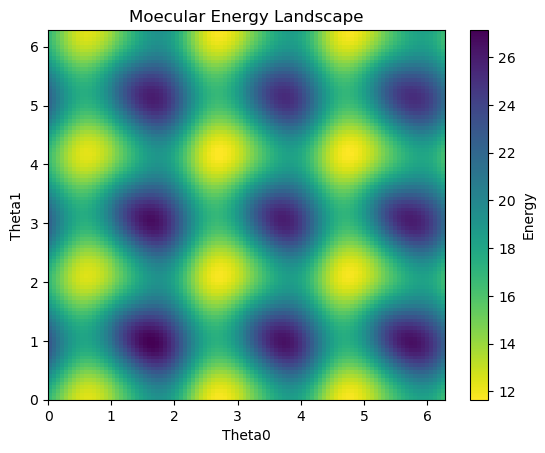

bond lengths tensor([1.1191, 1.1205, 1.1090, 1.5009, 1.5034, 1.5204, 1.1222, 1.1184, 1.1094,
        1.1078, 1.1132, 1.0937, 1.4944, 1.4396, 1.4664, 1.1102, 1.4333, 1.0434,
        1.6439, 1.4236, 1.4345, 1.4502, 1.2479, 1.4858, 1.1297, 1.0995, 1.3996,
        1.3857, 1.3849, 1.0684, 1.3762, 1.0891, 1.3804, 1.0964, 1.3770, 1.0750,
        1.0795])
energies (1st row) [310.82735626681, 363.381407741429, 428.05448554862625, 507.2894809835502, 603.6856157445574, 719.1691192649038, 853.3884739475649, 1001.433593474418, 1151.6721369350582, 1285.3159944777115, 1379.4795519306883, 1413.9883404591449, 1379.2604572772116, 1280.6582603192294, 1136.3755821395364, 970.3036605603394, 804.3200638213015, 653.642392078047, 525.9941798921744, 423.21057387745446, 343.5661951695201, 283.74878018517757, 240.1459581637782, 209.51770938838106, 189.2639353231846, 177.4672482510871, 172.83577547935866, 174.61321053003454, 182.48592246832996, 196.49558897810405, 216.95578831040845, 244.37169549577516, 279.36840

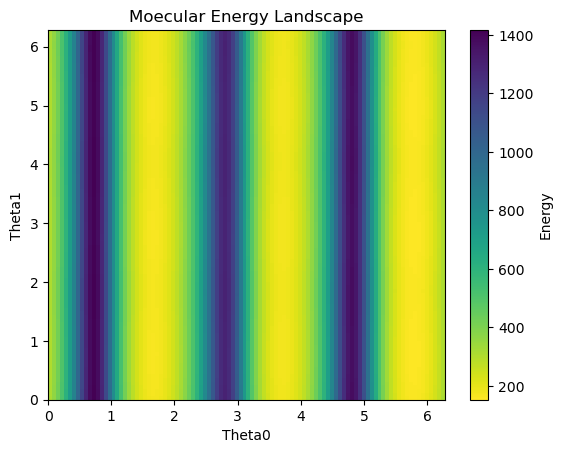

bond lengths tensor([1.1550, 1.1042, 1.1011, 1.4700, 1.5519, 1.4634, 1.1405, 1.0936, 1.1249,
        1.0944, 1.1387, 1.1381, 1.4706, 1.4941, 1.4924, 1.0879, 1.4217, 1.0240,
        1.6203, 1.4466, 1.4486, 1.4307, 1.2376, 1.4872, 1.1271, 1.1031, 1.3856,
        1.3786, 1.3775, 1.0991, 1.3752, 1.0724, 1.3816, 1.0889, 1.3773, 1.0791,
        1.0927])
energies (1st row) [269.15974034139754, 254.09302064653625, 232.2393187028965, 206.98553246383742, 181.49776267311822, 158.04464227683556, 137.8416171931013, 121.25166633901497, 108.10478998643441, 97.98002291818207, 90.3943361722567, 84.90516989743494, 81.15295897810518, 78.87060998720719, 77.87757440961624, 78.069121953559, 79.40594891251075, 81.90618663245172, 85.6396192794686, 90.72348935074179, 97.31761744044107, 105.6157465287258, 115.82811367249954, 128.1473933708669, 142.68633672730644, 159.3743773845138, 177.80755565679888, 197.07319275362764, 215.62138241586862, 231.31104031326308, 241.75926450919374, 244.9893097771904, 240.13866041

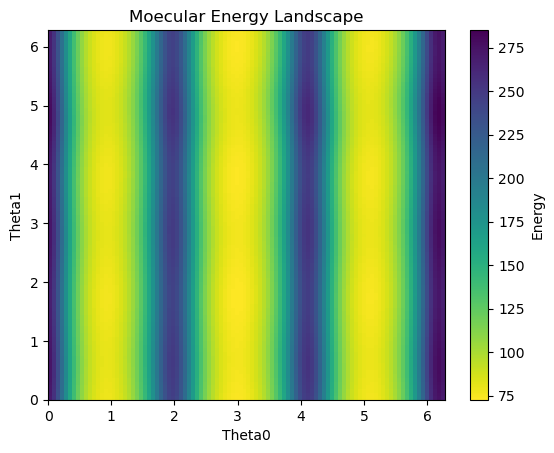

bond lengths tensor([1.1069, 1.1493, 1.1047, 1.5002, 1.5302, 1.4870, 1.1430, 1.1112, 1.1173,
        1.1122, 1.1290, 1.1381, 1.4687, 1.4135, 1.5113, 1.1356, 1.4581, 1.0155,
        1.6307, 1.4429, 1.4250, 1.4466, 1.2505, 1.4679, 1.1304, 1.1043, 1.3778,
        1.3788, 1.3787, 1.1016, 1.3790, 1.0801, 1.3642, 1.0905, 1.3965, 1.0812,
        1.0823])
energies (1st row) [57.45449189952039, 55.58595191010184, 54.72634828625334, 54.81433678538397, 55.824345814971906, 57.76340838020825, 60.667063297576895, 64.59448225498693, 69.62129166093465, 75.82929045561538, 83.29033362713211, 92.04246806661128, 102.0556861863227, 113.18515941333817, 125.1130667562975, 137.2872255949234, 148.88007325882592, 158.80840884548223, 165.8611320483872, 168.94875362618487, 167.417486712427, 161.2924864984566, 151.3162349923635, 138.74524854982664, 125.00470917106124, 111.36182708009574, 98.73194739861077, 87.63882477906121, 78.2799923237156, 70.63303549410904, 64.55633926366318, 59.86354321554911, 56.370007355606

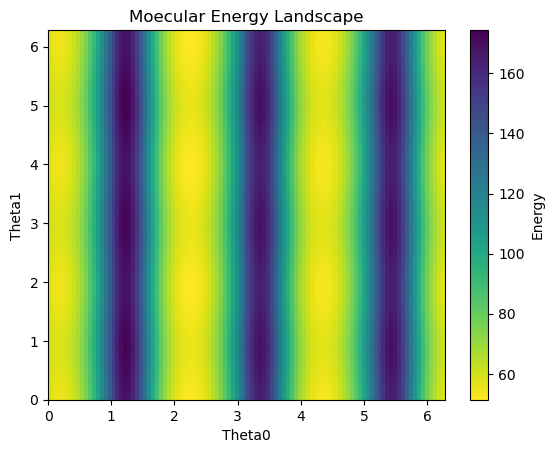

bond lengths tensor([1.1286, 1.1154, 1.0972, 1.5352, 1.4881, 1.4981, 1.1229, 1.1297, 1.0853,
        1.1283, 1.0926, 1.1030, 1.4998, 1.4486, 1.4724, 1.1121, 1.4225, 1.0430,
        1.6406, 1.4432, 1.4106, 1.4536, 1.2411, 1.4677, 1.1211, 1.1183, 1.3869,
        1.3789, 1.3764, 1.0811, 1.3741, 1.0765, 1.3663, 1.0913, 1.3911, 1.0833,
        1.0862])
energies (1st row) [154.12978526861923, 140.19545322011572, 127.59918309614719, 116.71441179238818, 107.70129759286385, 100.57336239186361, 95.26029927594863, 91.65743038900632, 89.65946913474843, 89.18037807171612, 90.16260432098184, 92.5782343139438, 96.42429326704746, 101.71290042240614, 108.45796876591066, 116.65954368476807, 126.2888566948267, 137.27879940046142, 149.52384095873873, 162.89106681911278, 177.2356308727247, 192.4040277721934, 208.20085684043067, 224.30307248344394, 240.12927750201447, 254.72032478229832, 266.7175820428537, 274.52675953567825, 276.67957467022745, 272.28553553425667, 261.3794447022022, 244.98599638132737, 224

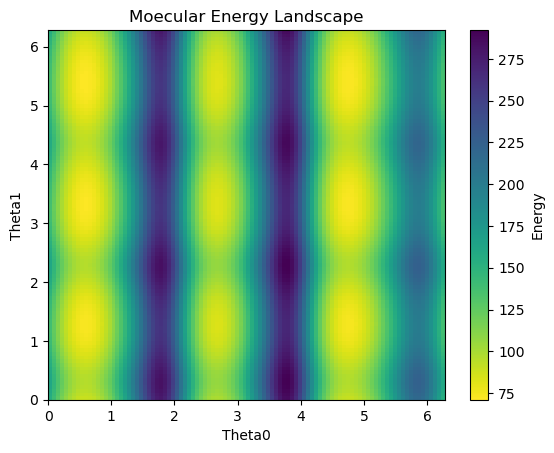

bond lengths tensor([1.1239, 1.1032, 1.1414, 1.4803, 1.5334, 1.4882, 1.1277, 1.0945, 1.0904,
        1.1164, 1.1269, 1.1311, 1.4673, 1.4285, 1.5191, 1.1469, 1.4643, 1.0223,
        1.6427, 1.4224, 1.4341, 1.4248, 1.2388, 1.4857, 1.1249, 1.1211, 1.3787,
        1.3786, 1.3842, 1.0805, 1.3744, 1.0796, 1.3690, 1.0907, 1.3996, 1.0749,
        1.0734])
energies (1st row) [82.89668033872348, 82.80959927467333, 82.81163774683742, 82.90340795331991, 83.08195572431742, 83.34082807160132, 83.67028444552645, 84.05774435770898, 84.48833471493664, 84.94558934898451, 85.41220333369903, 85.8708808967812, 86.30509078381637, 86.69970600799788, 87.04161148907549, 87.32000694823178, 87.52664726087563, 87.655881296266, 87.70456881808904, 87.6720284671304, 87.55984089499292, 87.37172184267739, 87.11349341154231, 86.79288324079319, 86.41956343442932, 86.00497717061172, 85.56216414426346, 85.10553536166775, 84.65043654760261, 84.21266114063475, 83.8078112664896, 83.45062838737002, 83.15428541668797, 82.92976

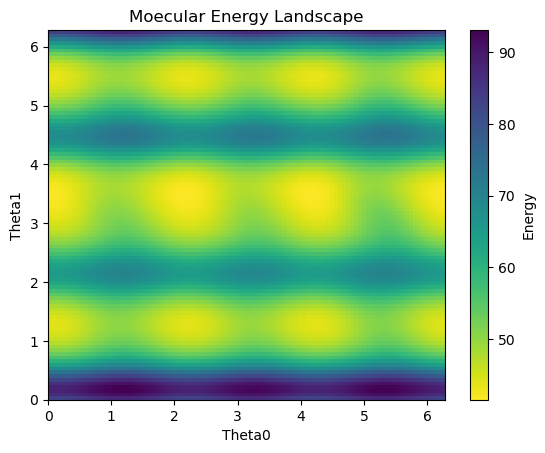

bond lengths tensor([1.1078, 1.0997, 1.1091, 1.5115, 1.4917, 1.5047, 1.1167, 1.1037, 1.1100,
        1.1098, 1.1101, 1.1146, 1.4987, 1.4426, 1.5067, 1.1006, 1.4222, 1.0587,
        1.6412, 1.4210, 1.4353, 1.4572, 1.2428, 1.4854, 1.1284, 1.1015, 1.3754,
        1.3595, 1.3820, 1.0759, 1.3737, 1.0881, 1.3636, 1.0964, 1.3947, 1.0685,
        1.0883])
energies (1st row) [20.292118293915003, 20.296140503849877, 20.377675295169617, 20.533192484262297, 20.757038725845046, 21.041648694995995, 21.377758578528038, 21.75460342570799, 22.160130212496234, 22.58121872961238, 23.003942832545214, 23.413844985671314, 23.796305092969323, 24.136970519615506, 24.42227811110627, 24.64008973420903, 24.780359375523236, 24.835812241612675, 24.80259291298083, 24.680709434088843, 24.47422681190665, 24.19122952157902, 23.84337628390195, 23.44525596231802, 23.013488136570935, 22.565787591535035, 22.119958992206698, 21.693074646762945, 21.30069620814593, 20.956365049612824, 20.671193812165452, 20.453663615856634, 

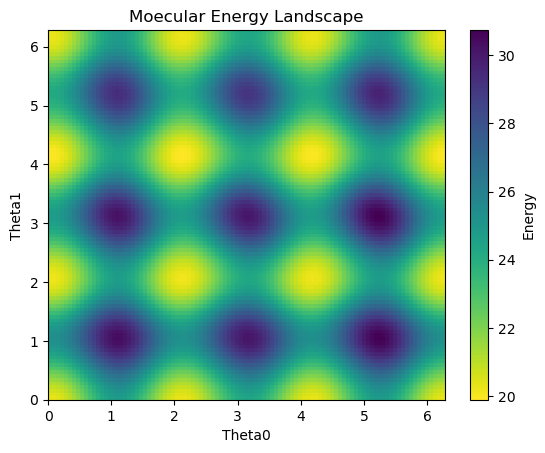

bond lengths tensor([1.1046, 1.1057, 1.1201, 1.5296, 1.5039, 1.4921, 1.0934, 1.1131, 1.1095,
        1.1284, 1.1046, 1.1155, 1.5083, 1.4280, 1.4868, 1.1163, 1.4206, 1.0384,
        1.6455, 1.4323, 1.4140, 1.4347, 1.2699, 1.4529, 1.1300, 1.1293, 1.3680,
        1.3707, 1.3790, 1.0975, 1.3709, 1.1037, 1.3857, 1.0720, 1.3798, 1.0797,
        1.1021])
energies (1st row) [13.152864783499847, 12.748034906788444, 12.507808438277689, 12.426713312712106, 12.494434087577584, 12.697798513927136, 13.02245386382064, 13.4542751557921, 13.980318698173996, 14.589287179414477, 15.271442942080146, 16.01799434107577, 16.819887855260255, 17.66618680314074, 18.542128406414953, 19.427066271654162, 20.292790920540483, 21.10277671451303, 21.812944127073855, 22.37450707214854, 22.739063775047676, 22.86530072079723, 22.726136189557486, 22.3146062659927, 21.646722219466685, 20.760508945806496, 19.71126851473003, 18.564475463985822, 17.387851869391003, 16.244443059660973, 15.187669105970546, 14.258685311978248, 1

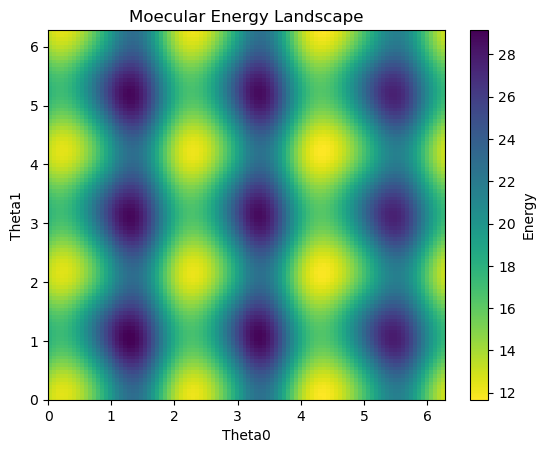

bond lengths tensor([1.1019, 1.1194, 1.1150, 1.5206, 1.4963, 1.4841, 1.1109, 1.1169, 1.1066,
        1.0861, 1.1208, 1.0952, 1.5000, 1.4287, 1.4856, 1.1000, 1.4223, 1.0430,
        1.6390, 1.4331, 1.4204, 1.4434, 1.2794, 1.4822, 1.1062, 1.1296, 1.3808,
        1.3843, 1.3845, 1.0942, 1.3787, 1.0693, 1.3787, 1.0938, 1.3812, 1.0867,
        1.0875])
energies (1st row) [37.732940283313965, 37.427009955181674, 36.86886498376252, 36.09806584311188, 35.16070051968403, 34.10486705525328, 32.977244228820545, 31.820996292703544, 30.674786030025235, 29.572606606798328, 28.544053353571964, 27.61486542392434, 26.807519929380735, 26.14182546944406, 25.635451693431225, 25.304337047704326, 25.16291802532395, 25.224091530086515, 25.49889589589434, 25.99582052915, 26.719702556283384, 27.670162215844424, 28.839479313270115, 30.210062044127728, 31.751669396496826, 33.41889053317549, 35.1498174279548, 36.866960814608674, 38.481175668673416, 39.899164129256846, 41.033694094945744, 41.814725748429666, 42.19

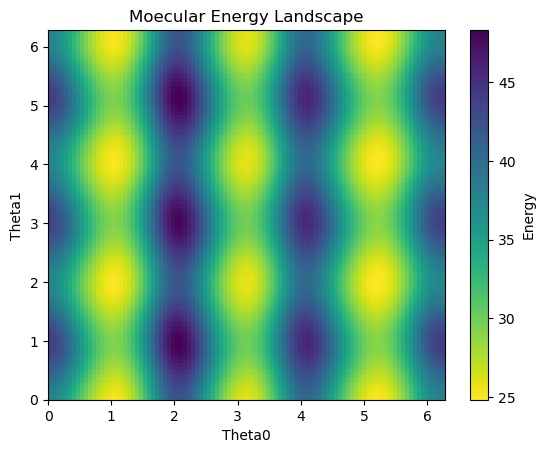

bond lengths tensor([1.1225, 1.0964, 1.1035, 1.5124, 1.5034, 1.5057, 1.1255, 1.1185, 1.1111,
        1.1091, 1.0987, 1.1142, 1.5141, 1.4699, 1.4655, 1.0990, 1.4282, 1.0241,
        1.6243, 1.4164, 1.4130, 1.4662, 1.2468, 1.4662, 1.1071, 1.1173, 1.3588,
        1.3806, 1.3810, 1.0682, 1.3738, 1.0925, 1.3738, 1.0973, 1.3829, 1.0855,
        1.0850])
energies (1st row) [14.41918117800904, 14.929825600059647, 15.436049275558169, 15.931067238918537, 16.407743957930364, 16.85715839956123, 17.2673678544906, 17.62273450975138, 17.904061189581174, 18.089815146552727, 18.15840969792794, 18.091440906313185, 17.87720556573777, 17.513872873642608, 17.011478882074528, 16.39211547222402, 15.688360460552623, 14.939992755397302, 14.189938263774138, 13.480042286813667, 12.847512445039737, 12.322275463377846, 11.925539717432198, 11.66928722196166, 11.556687358675696, 11.583023812276927, 11.73706853588947, 12.002673034708945, 12.360481096806236, 12.789689427604596, 13.269678771500477, 13.781501958771823, 

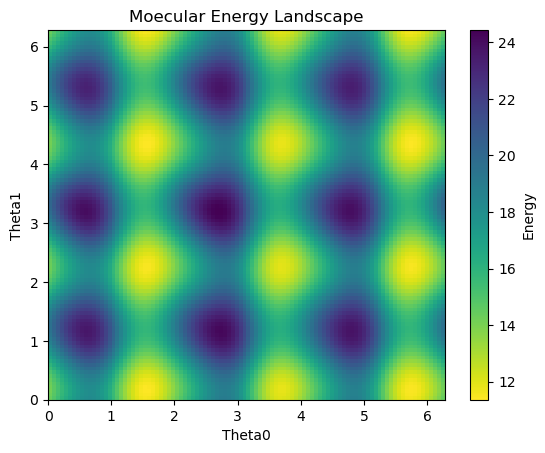

bond lengths tensor([1.1176, 1.0998, 1.1096, 1.5269, 1.5221, 1.5077, 1.0889, 1.1082, 1.0923,
        1.1230, 1.1160, 1.0879, 1.4971, 1.4504, 1.4596, 1.1104, 1.4147, 1.0410,
        1.6664, 1.4140, 1.4112, 1.4681, 1.2501, 1.4933, 1.0898, 1.1044, 1.3793,
        1.3889, 1.3776, 1.0980, 1.3777, 1.0958, 1.3773, 1.0868, 1.3785, 1.0917,
        1.0992])
energies (1st row) [12.835870036372821, 13.0650908078253, 13.251042442659326, 13.391194894428052, 13.481275975348096, 13.515028944213269, 13.48453546089709, 13.381262538344743, 13.197656145930523, 12.929161349116267, 12.576255467770697, 12.14609071908999, 11.653320607037363, 11.119783980885904, 10.573043256220735, 10.04399474181529, 9.563905136034865, 9.161495414727295, 8.86037860648569, 8.677241097704107, 8.620793235374672, 8.691574758993434, 8.882421311865622, 9.179452123332236, 9.563506486422657, 10.011804859305137, 10.499720738547246, 11.002582615316987, 11.49734927177696, 11.963985576282887, 12.386515677414113, 12.753646510310094, 13.058

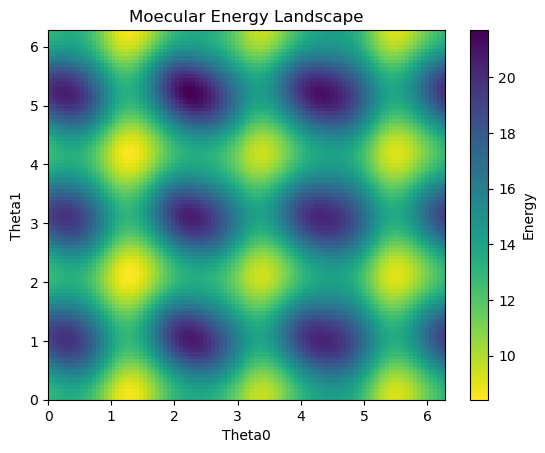

bond lengths tensor([1.1136, 1.1011, 1.1224, 1.5167, 1.5115, 1.4880, 1.1256, 1.1131, 1.1065,
        1.1148, 1.1073, 1.1009, 1.4960, 1.4241, 1.4859, 1.1105, 1.4279, 1.0478,
        1.6368, 1.4416, 1.4234, 1.4388, 1.2629, 1.4631, 1.0990, 1.1243, 1.3786,
        1.3771, 1.3929, 1.0844, 1.3801, 1.0875, 1.3785, 1.0912, 1.3861, 1.0907,
        1.0850])
energies (1st row) [32.48012267760126, 32.57629842025676, 32.783852723429135, 33.09831313207772, 33.51235071607263, 34.01560066633897, 34.59450636277314, 35.23216692760537, 35.908249397534014, 36.59923286687248, 37.27887983162156, 37.91915882557454, 38.49167907927203, 38.96950825326583, 39.32924398050311, 39.55301198572444, 39.6300758030044, 39.55769314639396, 39.341147616725394, 38.99296750460418, 38.53148685977284, 37.97915421472622, 37.36072277328682, 36.70166626433225, 36.02688043087009, 35.35972997076613, 34.72139673147468, 34.13055696819209, 33.60319853484819, 33.15262322668772, 32.789493250939614, 32.52188194007127, 32.35534280943506, 

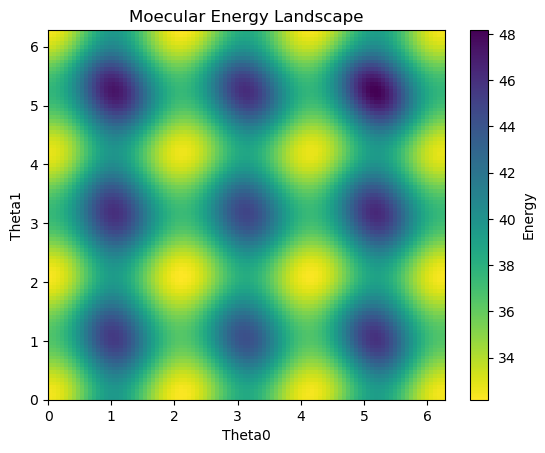

bond lengths tensor([1.0875, 1.1005, 1.1138, 1.5186, 1.5136, 1.4891, 1.0950, 1.1070, 1.1222,
        1.0905, 1.1311, 1.1269, 1.4913, 1.4242, 1.4742, 1.1311, 1.4214, 1.0484,
        1.6507, 1.4107, 1.4163, 1.4708, 1.2594, 1.4870, 1.0919, 1.1028, 1.3648,
        1.3719, 1.3895, 1.0862, 1.3837, 1.0938, 1.3767, 1.0816, 1.3808, 1.0791,
        1.0887])
energies (1st row) [43.4854405659734, 47.30236342746128, 51.71502536082127, 56.74369457305643, 62.36629287432107, 68.48731503254635, 74.90656621964803, 81.2973798132856, 87.2095063705849, 92.10883228985352, 95.45765439934752, 96.82176633732186, 95.97259115844432, 92.94926978527226, 88.05389206523256, 81.78329790133648, 74.72356565027451, 67.44402832551066, 60.419961090848425, 53.99558833888081, 48.38259725969872, 43.681502707132246, 39.91197084904663, 37.04294439973882, 35.01720099338534, 33.769121047725314, 33.236410182956114, 33.367185751382316, 34.12417530598173, 35.487013373567216, 37.45346742954806, 40.039482032596275, 43.277279771220904

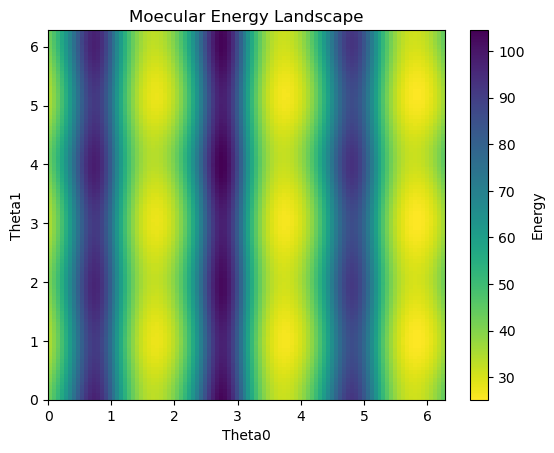

bond lengths tensor([1.1184, 1.1249, 1.0912, 1.5350, 1.5171, 1.4901, 1.0935, 1.1089, 1.1280,
        1.1104, 1.0885, 1.1112, 1.5062, 1.4181, 1.4614, 1.1100, 1.4165, 1.0321,
        1.6484, 1.4283, 1.4182, 1.4462, 1.2774, 1.4717, 1.1086, 1.1071, 1.3787,
        1.3770, 1.3771, 1.0985, 1.3777, 1.0917, 1.3851, 1.0963, 1.3872, 1.0868,
        1.0644])
energies (1st row) [28.068694860899953, 28.151119397686116, 28.37373677283294, 28.731607648062763, 29.217204065635116, 29.82018244294042, 30.52729305124185, 31.322318454071272, 32.18606590412997, 33.09642449899405, 34.028552534825536, 34.95495497197252, 35.845681347068314, 36.66866886482838, 37.39045991345151, 37.97759079713839, 38.39879232746074, 38.62784073654157, 38.64682410558072, 38.44893379502997, 38.04029311840242, 37.440014387852955, 36.678656158555434, 35.79524499891989, 34.833590766125475, 33.83858148757051, 32.85311084470373, 31.915819308464982, 31.059773601491734, 30.311887867079342, 29.692969346812305, 29.218079317106458, 28.8970

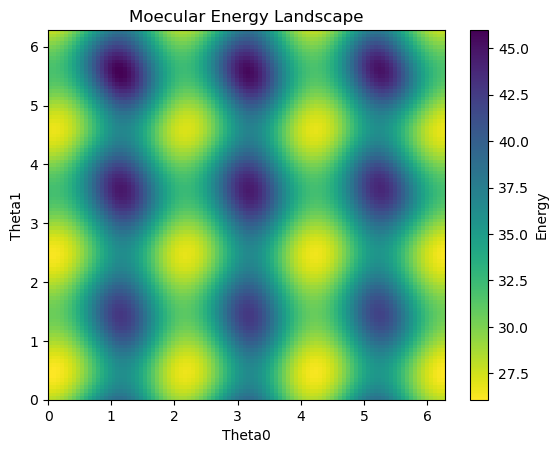

bond lengths tensor([1.1067, 1.1005, 1.1153, 1.5166, 1.4910, 1.5052, 1.1205, 1.1303, 1.1165,
        1.1037, 1.1241, 1.1229, 1.4948, 1.4440, 1.4841, 1.1171, 1.4230, 1.0449,
        1.6532, 1.4210, 1.4197, 1.4584, 1.2526, 1.4760, 1.1199, 1.1178, 1.3754,
        1.3772, 1.3786, 1.0795, 1.3924, 1.0850, 1.3629, 1.0785, 1.3870, 1.0837,
        1.0926])
energies (1st row) [17.00047435340014, 17.043110414672245, 17.15468987449808, 17.333392344800902, 17.575246432274618, 17.87387023924152, 18.220259484983764, 18.602759705929948, 19.00732417318625, 19.41797915204447, 19.817590041481342, 20.188782579659772, 20.515013766071807, 20.781608251927086, 20.976716925011434, 21.092047390127195, 21.123283571296557, 21.070218458166583, 20.93654484027451, 20.729405467144037, 20.45875362270829, 20.136644702099915, 19.77649781545856, 19.39238127511749, 18.998409687025035, 18.608237628847583, 18.234612486797097, 17.889136899040103, 17.582020382064634, 17.32205764027876, 17.11656705419663, 16.971421418727235, 1

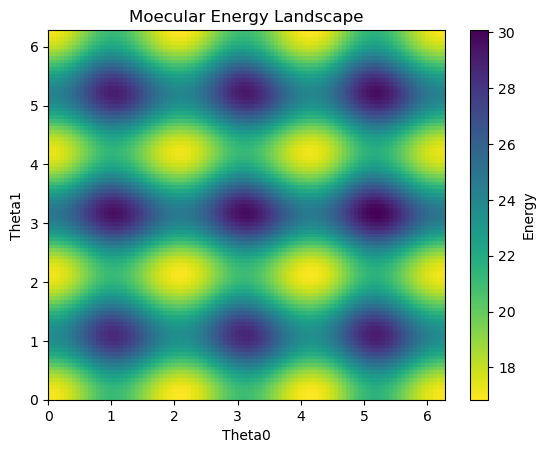

bond lengths tensor([1.1223, 1.1160, 1.0982, 1.5259, 1.5014, 1.5081, 1.1099, 1.1239, 1.1269,
        1.1061, 1.0956, 1.1158, 1.5092, 1.4401, 1.4729, 1.1171, 1.4154, 1.0535,
        1.6212, 1.4394, 1.4143, 1.4489, 1.2598, 1.4783, 1.0959, 1.1236, 1.3754,
        1.3875, 1.3891, 1.0700, 1.3791, 1.0814, 1.3721, 1.0801, 1.3625, 1.0968,
        1.0662])
energies (1st row) [110.55261477836568, 92.41232544272101, 77.94915443839783, 66.78418731172854, 58.4591851753204, 52.53380641660965, 48.63678452222959, 46.48804957412367, 45.90552907985805, 46.8055805753281, 49.20179397114592, 53.204442707842134, 59.01905414951746, 66.94099614632563, 77.33850530098414, 90.61315499595445, 107.12286101370422, 127.05242940008195, 150.22687482323886, 175.8875849839389, 202.5007887976986, 227.7122536227825, 248.58251476255205, 262.1548913589852, 266.2348580717751, 260.07356287791623, 244.62470207567563, 222.2324621580525, 195.91810295846665, 168.60850987744777, 142.59521172435922, 119.33131743431953, 99.496904786

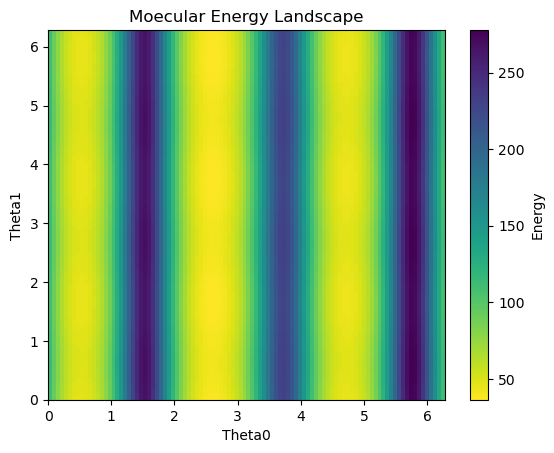

bond lengths tensor([1.0914, 1.1076, 1.1291, 1.5115, 1.5359, 1.4837, 1.1248, 1.1006, 1.1189,
        1.1101, 1.1047, 1.1278, 1.4885, 1.4350, 1.4509, 1.1339, 1.4195, 1.0426,
        1.6568, 1.4176, 1.4082, 1.4543, 1.2510, 1.4727, 1.1080, 1.1180, 1.3771,
        1.3769, 1.3776, 1.0781, 1.3967, 1.0858, 1.3793, 1.0811, 1.4002, 1.0815,
        1.0820])
energies (1st row) [18.00880562104519, 17.885698169212368, 17.874099622196077, 17.971951841622435, 18.173341114246377, 18.469127864160107, 18.847608536104424, 19.29517132315977, 19.796912870222148, 20.337139251302663, 20.899776503591315, 21.46864711454271, 22.027647202389705, 22.56081191158869, 23.052386289960843, 23.48689545110118, 23.849351943515746, 24.12556450694975, 24.3027278449428, 24.370200107154425, 24.320472216449012, 24.150197675842172, 23.861181651838894, 23.46102153883847, 22.963314950344873, 22.387240613869142, 21.756554233617326, 21.098076277567774, 20.43986247059644, 19.809382650247276, 19.23179578988499, 18.728647783619728, 1

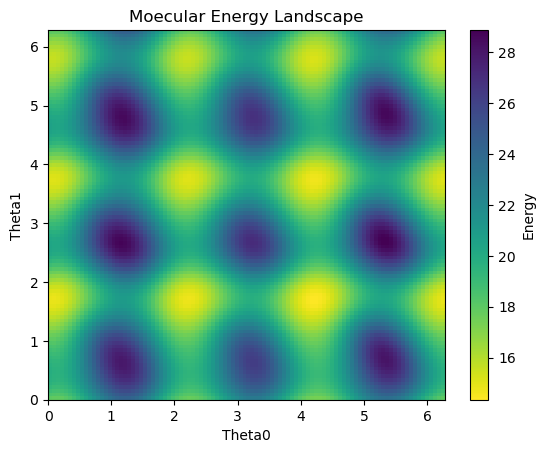

bond lengths tensor([1.1277, 1.1250, 1.0945, 1.4945, 1.5341, 1.5121, 1.0949, 1.0897, 1.1223,
        1.1094, 1.1071, 1.1085, 1.5087, 1.4485, 1.4867, 1.0909, 1.4223, 1.0409,
        1.6430, 1.4360, 1.4229, 1.4438, 1.2622, 1.4878, 1.1082, 1.1115, 1.3757,
        1.3770, 1.3960, 1.0687, 1.3724, 1.0677, 1.3664, 1.0782, 1.3950, 1.0790,
        1.0677])
energies (1st row) [28.224165774903756, 27.86834502767023, 27.619970457341125, 27.48621991096961, 27.47143565930297, 27.57727540512026, 27.802859715692605, 28.144830949338843, 28.597348365965193, 29.15207662549287, 29.79801617589175, 30.521361445184823, 31.305248685404052, 32.1294476483655, 32.970172870326394, 33.79999762744747, 34.58817817766153, 35.301482441051675, 35.90583891938819, 36.368681285500216, 36.66203020060725, 36.765673526429325, 36.66995967571454, 36.3775571485249, 35.90362727267005, 35.2744189356129, 34.524424525538066, 33.69293267177956, 32.82035859580307, 31.945349202060683, 31.10256460085654, 30.32153606370761, 29.626334990

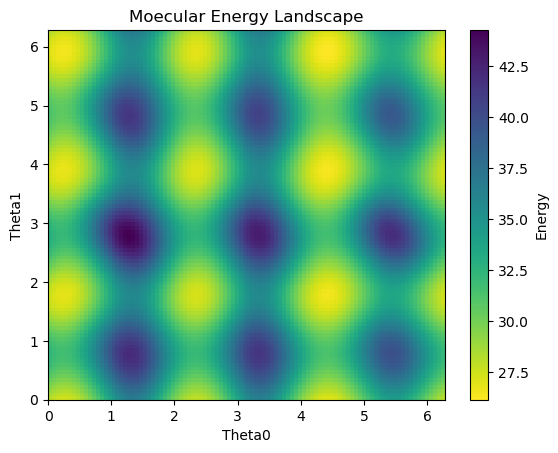

bond lengths tensor([1.1185, 1.1077, 1.1208, 1.5170, 1.4850, 1.4979, 1.1205, 1.1097, 1.1075,
        1.1241, 1.0886, 1.1214, 1.4848, 1.4531, 1.4886, 1.1094, 1.4454, 1.0414,
        1.6466, 1.4179, 1.4221, 1.4534, 1.2617, 1.4987, 1.1035, 1.1075, 1.3773,
        1.3915, 1.3946, 1.0952, 1.3785, 1.0764, 1.3784, 1.1010, 1.3782, 1.0692,
        1.0853])
energies (1st row) [16.80584124656994, 17.148998304366444, 17.531070595777546, 17.938787831402887, 18.357723257953236, 18.772732403100118, 19.16846487082631, 19.529964759256142, 19.843281405060207, 20.096105065623515, 20.27836059629815, 20.38275001112647, 20.405116736385345, 20.344728154837476, 20.204248926261908, 19.989630392583887, 19.709760270375266, 19.3759993574652, 19.00163390150291, 18.601268517577633, 18.190192471821202, 17.78382751820774, 17.397138386974063, 17.044159154877974, 16.737549069891458, 16.488231136796202, 16.305098707212778, 16.194785075082166, 16.16150378566914, 16.206997323226915, 16.33048531971582, 16.528756619281666, 

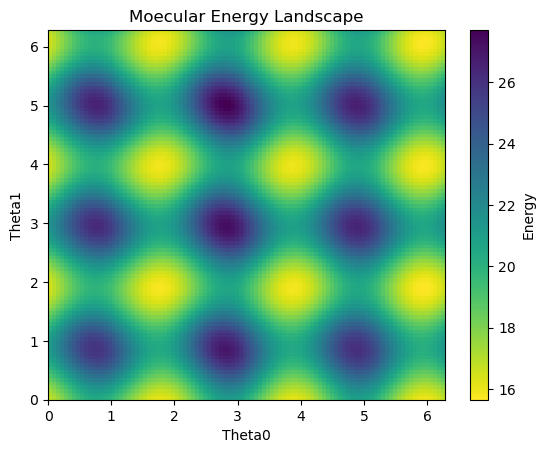

In [8]:
ix_smi = 489
datapoint = dataset.datapoints[ix_smi]
data = copy.deepcopy(datapoint)
for ix in range(len(data.pos)): # for each different values of bond lenghts and angles from ground truth data
    data.pos, data.weights = datapoint.pos[ix], datapoint.weights[ix]
    energy_landscape = get_2dheatmap_array(data,ix0=2, ix1=3)
    print('energies (1st row)', energy_landscape[0])
    #plot heatmap
    plt.figure()
    plt.imshow(energy_landscape, extent=[0, 2 * np.pi, 0, 2 * np.pi], origin='lower', aspect='auto', cmap='viridis_r')
    plt.colorbar(label='Energy')
    plt.xlabel('Theta0')
    plt.ylabel('Theta1')
    plt.title('Moecular Energy Landscape')
    plt.show()


In [25]:
ix_smi = 0
datapoint = dataset.datapoints[ix_smi]
data = copy.deepcopy(datapoint)
mols = []
for ix in range(len(data.pos)):
    data.pos, data.weights = datapoint.pos[ix], datapoint.weights[ix]
    mol = pyg_to_mol(data.mol, data, mmff=False, rmsd=True, copy=True)
    mols.append(mol)

get_stds_internal_coords(mols)

(tensor(0.0150), tensor(0.0328), tensor(1.5765))

In [9]:
mols_gen = list(conformers_gen.values())[0]
get_stds_internal_coords(mols_gen)

(tensor(0.0159), tensor(0.0701), tensor(1.5332))

In [10]:
bond_angles = [get_bond_angles(mol) for mol in mols]
bond_angles_gen = [get_bond_angles(mol)[:-1] for mol in mols_gen]
torch.stack(bond_angles + bond_angles_gen).std(dim=0).mean()

tensor(0.1286)

In [11]:
bond_lengths = [get_bond_lengths(mol) for mol in mols]
bond_lengths_gen = [get_bond_lengths(mol) for mol in mols_gen]
torch.stack(bond_lengths + bond_lengths_gen).std(dim=0).mean()

tensor(0.0986)

Hm, the std deviation of bond lengths&bond angles increases when we concatenate [mols_ground truth, mols_gen]. which seems to indicate a distributional shift in the lengths/angles distributions when we are moving from gt to rdkit-generated. Does this explain the energy-shifts?

## Visualise stuff for diffusion model

In [43]:
import pickle 
import matplotlib.pyplot as plt
import numpy as np
def read_pickle(name):
    return pickle.load(open(name, 'rb'))

energies_train_on_policy = read_pickle('energies_train_on_policy.pkl')
energies_train_rand = read_pickle('energies_train_rand.pkl')
logpT_train_on_policy = read_pickle('logpT_train_on_policy.pkl')
logpT_train_rand = read_pickle('logpT_train_rand.pkl')

In [44]:
len(energies_train_on_policy), len(energies_train_rand), len(logpT_train_on_policy), len(logpT_train_rand)

(1, 1, 1, 1)

In [47]:
energies_train_on_policy, energies_train_rand

({'Brc1c(CSc2nncn2-c2ccccc2)nc2sccn12': [80.856949958732,
   80.8569498021112,
   80.0960580608035,
   79.57293070460697,
   79.57293074984698,
   80.09605795863891,
   79.57293066128119,
   79.58636306343239]},
 {'Brc1c(CSc2nncn2-c2ccccc2)nc2sccn12': [79.5729306903002,
   79.84008309360625,
   79.57293116385799,
   81.31379715661552,
   80.09605798426031,
   1671.4826773733582,
   81.31379714279251,
   79.5864741915703]})

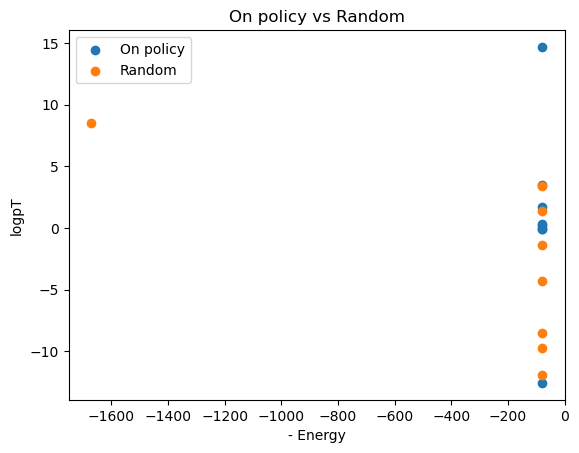

In [50]:
for ix in range(len(energies_train_on_policy)):
    smile = list(energies_train_on_policy.keys())[ix]
    plt.figure()
    plt.scatter(- np.array(energies_train_on_policy[smile]), logpT_train_on_policy[ix], label='On policy')
    plt.scatter( - np.array(energies_train_rand[smile]), logpT_train_rand[ix], label='Random')
    # Set title and labels
    plt.title('On policy vs Random')
    plt.xlabel('- Energy')
    plt.ylabel('logpT')
    plt.legend()
    plt.show()